Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.



Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties):

- Для модели выбрать тип виновника — только машина (car).

- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).

- Для моделирования ограничиться данными за 2012 год — они самые свежие.

- Обязательное условие — учесть фактор возраста автомобиля.

**Метрика** 


Решил выбрать roc_auc, т.к. заказчику нужна вероятность дтп с любым повреждением, что как раз нам и дает данная метрика, т.е. заказчик может сам регулировать планку, после какой вероятности клиенту не выдается машина.

In [1]:
# !pip install --user -U optuna
# !pip install --user -U shap

In [1]:
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score
from sklearn.svm import SVC
from sklearn import metrics

import optuna
from optuna import Trial

from lightgbm import LGBMClassifier 

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 
from scipy import stats
import numpy as np

pd.set_option("display.max_columns", 50)
sns.set_theme(style="darkgrid")

from IPython.display import Image

import shap

from catboost import cv, Pool, CatBoostClassifier

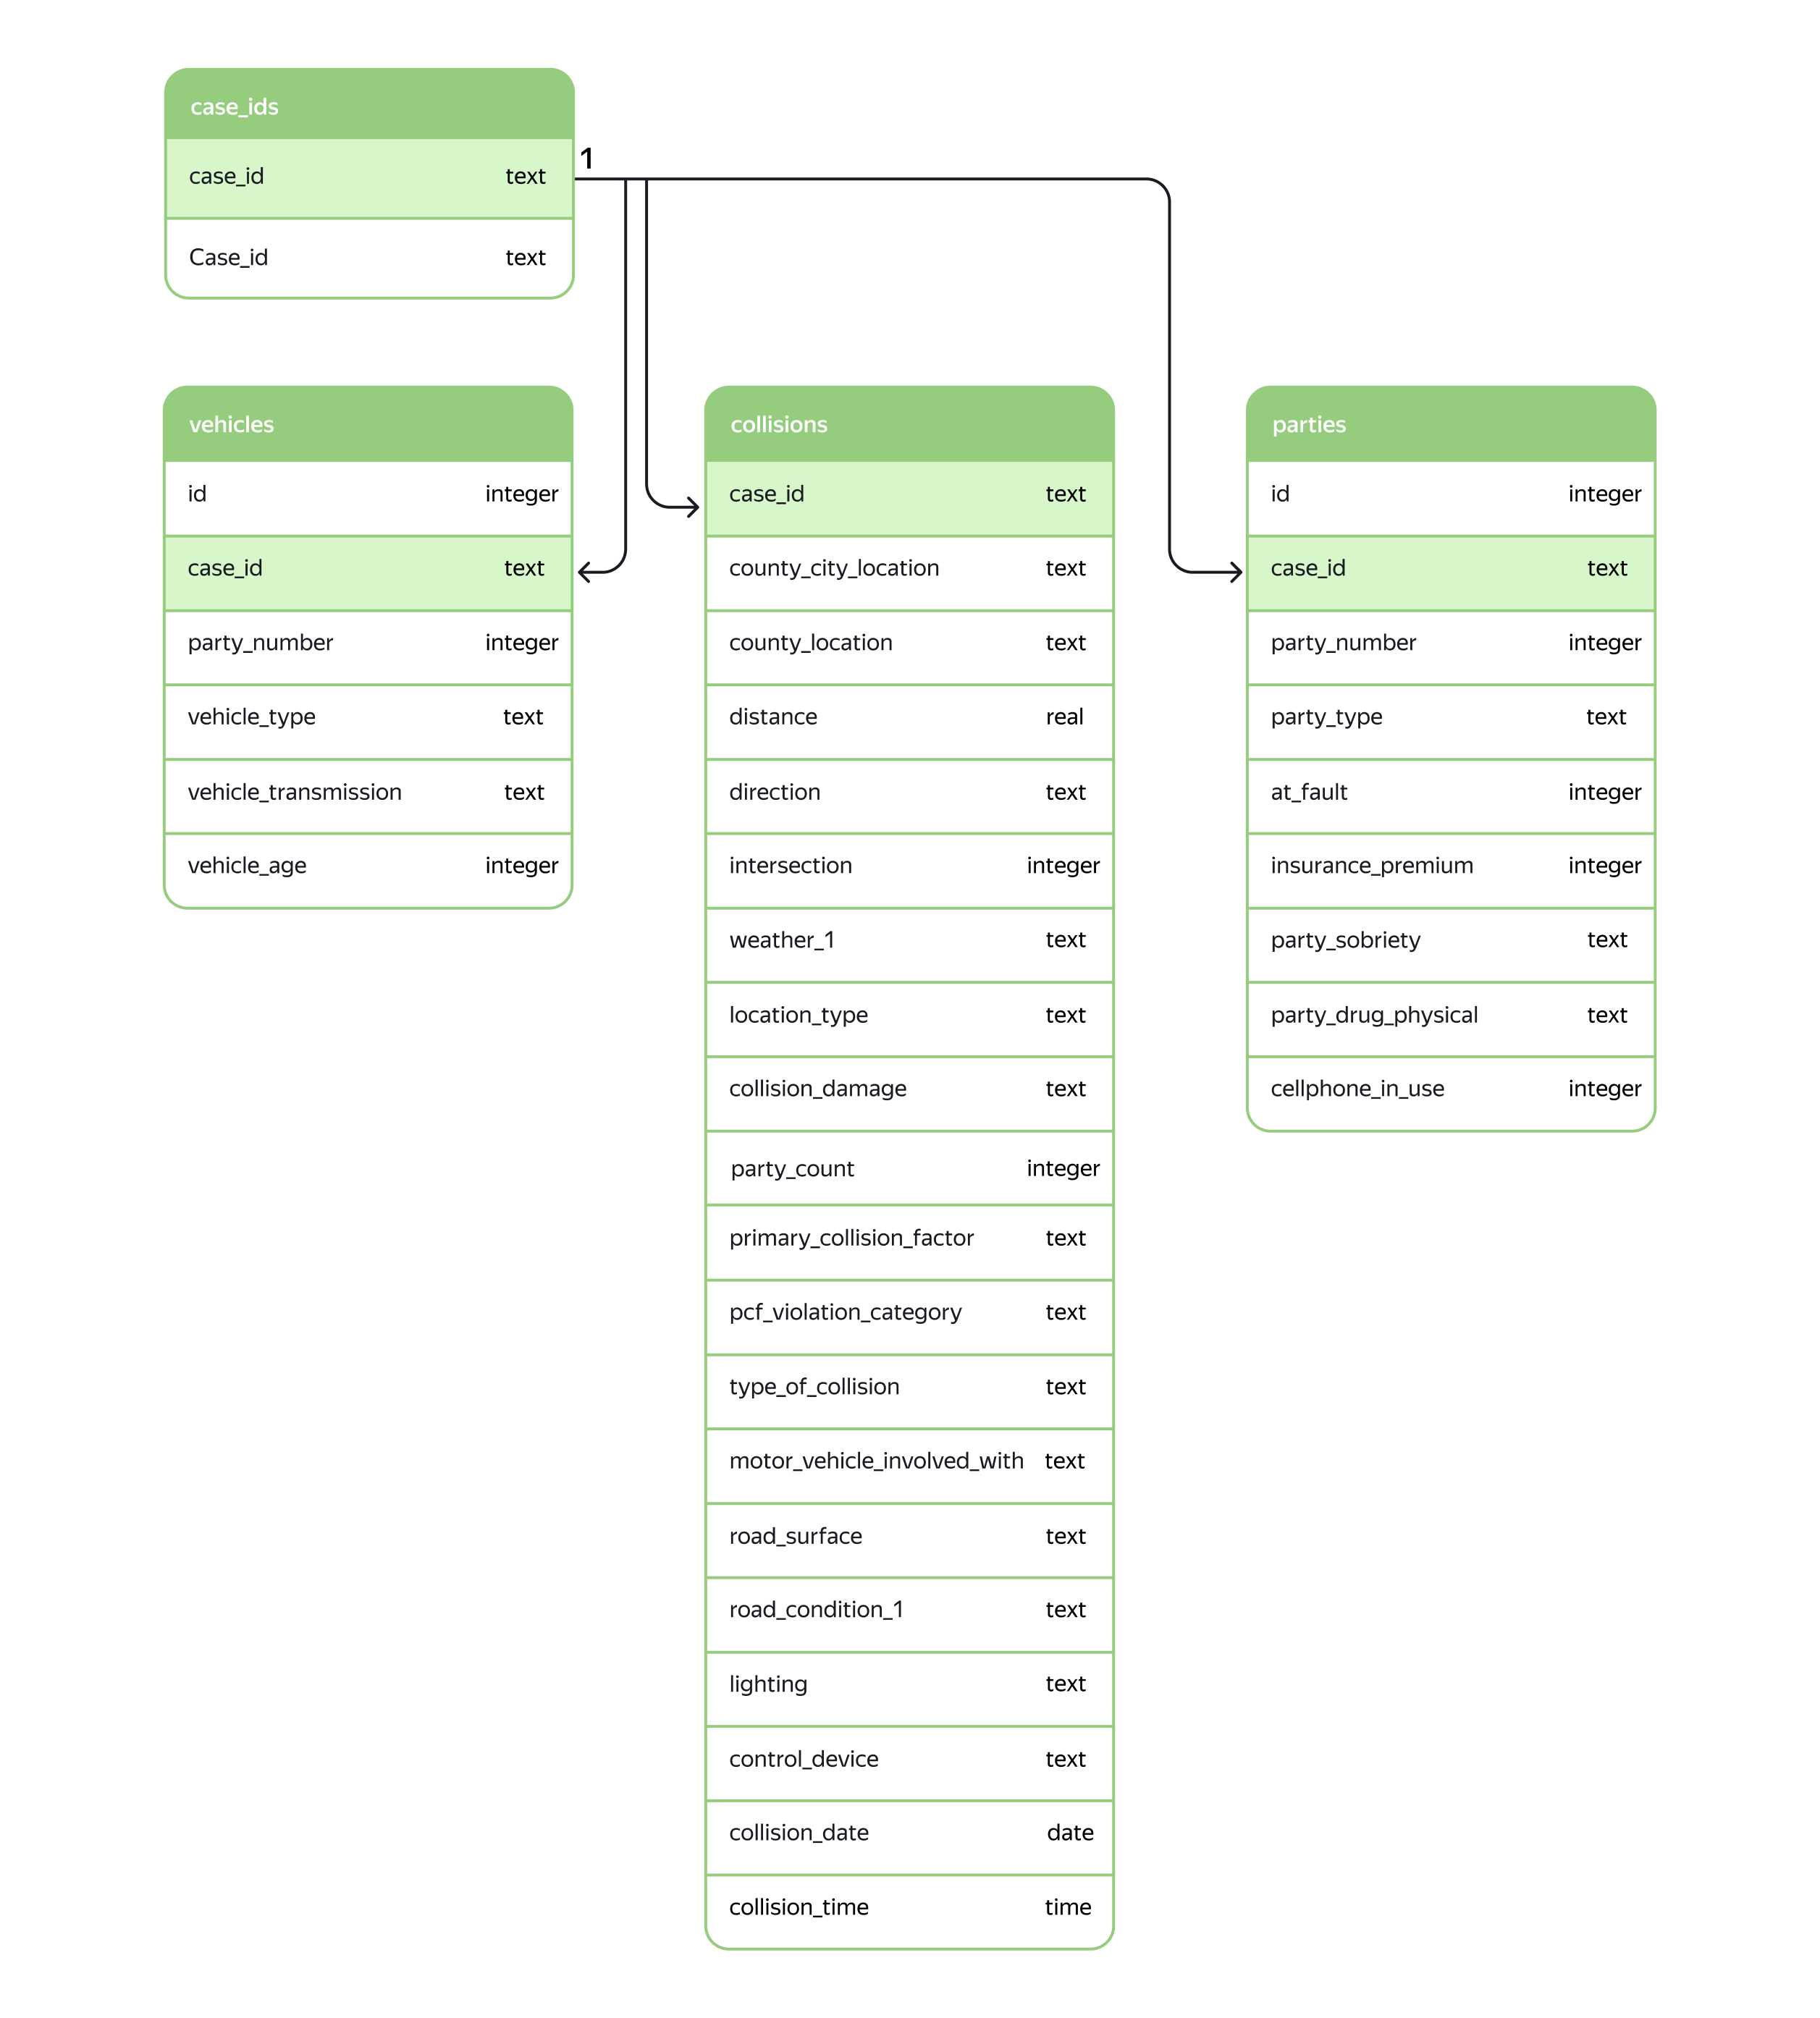

In [2]:
Image("C:/Users/nikit/Yandex/base_data.png")

# Описание данных

- `case_id` - Уникальный номер для зарегистрированного происшествия в таблице происшествий
- `collision_date` - Дата происшествия
- `collision_time` - Время происшествия
- `intersection` - Является ли место происшествие перекрёстком
- `collision_damage` - Серьёзность происшествия
- `weather_1` - Погода
- `primary_collision_factor` - Основной фактор аварии
- `road_surface` - Состояние дороги
- `lighting` - Освещение
- `county_city_location` - Номер географических районов, где произошло ДТП
- `country_location` - Названия географических районов, где произошло ДТП
- `direction` - Направление движения
- `distance` - Расстояние от главной дороги (метры)
- `location_type` - Тип дороги
- `party_count` - Количество участников
- `pcf_violation_category` - Категория нарушения
- `motor_vehicle_involved_with` - Дополнительные участники ДТП
- `road_condition_1` - Дорожное состояние
- `control_device` - Устройство управления
- `at_fault` - Виновность участника 
- `insurance_premium` - Сумма страховки (тыс.) PARTY_DRUG_PHYSICAL
- `party_drug_physical` - Состояние участника: физическое или с учётом принятых лекарств
- `party_sobriety` - Трезвость участника
- `cellphone_in_use` - Наличие телефона в автомобиле (возможности разговаривать по громкой связи)
- `id` - Индекс текущей таблицы
- `vehicle_type` - Тип кузова
- `vehicle_transmission` - Тип КПП
- `vehicle_age` - Возраст автомобиля (в годах)
- `party_number` - Номер пострадавшего

# Загрузка данных + осмотр данных

In [3]:
db_config = {
# удалил в целях безопасности
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string) 

In [5]:
def count_string(table):
    query = f'''
    SELECT COUNT(*) count_string_in_df
    FROM {table}
    '''
    df = pd.read_sql_query(query,con=engine)
    return df

In [7]:
count_string('case_ids')

,count_string_in_df
0,1400000


In [8]:
count_string('collisions')

,count_string_in_df
0,1400000


In [9]:
count_string('parties')

,count_string_in_df
0,2752408


In [10]:
count_string('vehicles')

,count_string_in_df
0,1021234


Среди всех таблиц самое максимальное количество данных - таблица parties

In [12]:
query = f'''
SELECT COUNT(*) count_string_in_df
FROM collisions c
INNER JOIN parties p ON c.case_id = p.case_id
INNER JOIN vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car';
'''
df = pd.read_sql_query(query,con=engine)

In [13]:
df

,count_string_in_df
0,923790


В итоге получилось 924 тысячи данных, где тип участника - машина.

In [14]:
query = f'''
SELECT *
FROM collisions c
INNER JOIN parties p ON c.case_id = p.case_id
INNER JOIN vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car'
LIMIT 20;
'''
df = pd.read_sql_query(query,con=engine)

In [15]:
df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,4039007,3026,orange,0.0,None,1,clear,None,scratch,2,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-17,15:02:00,14558,4039007,2,car,0,34,had not been drinking,None,0,7817,4039007,2,coupe,auto,5
1,4041490,4316,santa clara,200.0,south,0,raining,ramp,scratch,1,vehicle code violation,improper turning,hit object,fixed object,wet,normal,dark with street lights,none,2009-01-05,18:45:00,17147,4041490,1,car,1,23,had not been drinking,None,0,9155,4041490,1,coupe,auto,3
2,4044978,1942,los angeles,0.0,None,1,clear,None,middle damage,2,vehicle code violation,traffic signals and signs,other,bicycle,dry,normal,daylight,functioning,2009-01-06,16:00:00,22359,4044978,1,car,0,21,had not been drinking,None,0,11978,4044978,1,sedan,manual,0
3,4055170,1956,los angeles,0.0,None,1,clear,None,scratch,2,vehicle code violation,wrong side of road,broadside,bicycle,dry,normal,daylight,none,2009-01-10,16:30:00,25962,4055170,2,car,0,57,had not been drinking,None,0,13898,4055170,2,sedan,manual,0
4,4091316,4313,santa clara,750.0,south,0,cloudy,highway,scratch,4,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,dark with no street lights,none,2009-01-24,02:14:00,47403,4091316,3,car,0,29,had not been drinking,None,0,25263,4091316,3,sedan,manual,4
5,4112279,2400,merced,0.0,None,1,raining,intersection,scratch,3,vehicle code violation,automobile right of way,broadside,other motor vehicle,wet,normal,dusk or dawn,none,2009-02-06,17:05:00,75314,4112279,2,car,0,47,had not been drinking,None,0,39428,4112279,2,coupe,manual,7
6,4113042,2105,marin,614.0,south,0,cloudy,None,middle damage,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,daylight,none,2009-02-09,15:24:00,76531,4113042,2,car,0,39,had not been drinking,None,0,40050,4113042,2,sedan,auto,0
7,4175924,0303,amador,0.0,None,1,clear,intersection,small damage,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-03-17,15:15:00,166991,4175924,1,car,1,65,had not been drinking,None,0,87438,4175924,1,sedan,auto,10
8,4182577,4200,santa barbara,75.0,south,0,clear,None,small damage,2,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,daylight,functioning,2009-04-04,19:00:00,178746,4182577,2,car,0,24,had not been drinking,None,0,94305,4182577,2,sedan,auto,3
9,4189250,1942,los angeles,147.0,west,0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,none,2009-03-29,07:55:00,190182,4189250,1,car,1,22,had not been drinking,None,0,100413,4189250,1,coupe,manual,3


Интересно получается, что у нас строения могут быть не пьющими и т.д. Так еще и иметь страховку. Нужно будет отчищать в анализе данные, т.е. брать party_type = car. Т.к. анализ будет испорчен такими строчками.

In [19]:
# функции для осмотра данных
def nan_count_sql(table, column):
    print(f'Таблица {table}, колонка {column}')
    query = f'''
    SELECT COUNT(*) {column}_nan_count
    FROM {table}
    WHERE {column} IS NULL
    '''
    df = pd.read_sql_query(query,con=engine)
    return df



def nan_for_full_df(table):
    for column in info_sql(table)['column_name'].unique():
        try:
            print('----------------------------------')
            display(nan_count_sql(table, column))
        except:
            print('Произошла ошибка')




def info_sql(table):
    query = f'''
    SELECT column_name, data_type
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE table_name = '{table}'
    '''

    df = pd.read_sql_query(query,con=engine)
    return df

In [20]:
info_sql('case_ids')

,column_name,data_type
0,case_id,text
1,db_year,text


In [21]:
info_sql('vehicles')

,column_name,data_type
0,id,integer
1,case_id,text
2,party_number,integer
3,vehicle_type,text
4,vehicle_transmission,text
5,vehicle_age,integer


In [22]:
nan_for_full_df('vehicles')

----------------------------------
Таблица vehicles, колонка id


,id_nan_count
0,0


----------------------------------
Таблица vehicles, колонка case_id


,case_id_nan_count
0,0


----------------------------------
Таблица vehicles, колонка party_number


,party_number_nan_count
0,0


----------------------------------
Таблица vehicles, колонка vehicle_type


,vehicle_type_nan_count
0,0


----------------------------------
Таблица vehicles, колонка vehicle_transmission


,vehicle_transmission_nan_count
0,23659


----------------------------------
Таблица vehicles, колонка vehicle_age


,vehicle_age_nan_count
0,24582


In [23]:
info_sql('parties')

,column_name,data_type
0,id,integer
1,case_id,text
2,party_number,integer
3,party_type,text
4,at_fault,integer
5,insurance_premium,integer
6,party_sobriety,text
7,party_drug_physical,text
8,cellphone_in_use,integer


In [24]:
nan_for_full_df('parties')

----------------------------------
Таблица parties, колонка id


,id_nan_count
0,0


----------------------------------
Таблица parties, колонка case_id


,case_id_nan_count
0,0


----------------------------------
Таблица parties, колонка party_number


,party_number_nan_count
0,0


----------------------------------
Таблица parties, колонка party_type


,party_type_nan_count
0,3622


----------------------------------
Таблица parties, колонка at_fault


,at_fault_nan_count
0,0


----------------------------------
Таблица parties, колонка insurance_premium


,insurance_premium_nan_count
0,405402


----------------------------------
Таблица parties, колонка party_sobriety


,party_sobriety_nan_count
0,73955


----------------------------------
Таблица parties, колонка party_drug_physical


,party_drug_physical_nan_count
0,2320120


----------------------------------
Таблица parties, колонка cellphone_in_use


,cellphone_in_use_nan_count
0,511637


In [25]:
info_sql('collisions')

,column_name,data_type
0,case_id,text
1,county_city_location,text
2,county_location,text
3,distance,real
4,direction,text
5,intersection,integer
6,weather_1,text
7,location_type,text
8,collision_damage,text
9,party_count,integer


In [26]:
nan_for_full_df('collisions')

----------------------------------
Таблица collisions, колонка case_id


,case_id_nan_count
0,0


----------------------------------
Таблица collisions, колонка county_city_location


,county_city_location_nan_count
0,0


----------------------------------
Таблица collisions, колонка county_location


,county_location_nan_count
0,0


----------------------------------
Таблица collisions, колонка distance


,distance_nan_count
0,0


----------------------------------
Таблица collisions, колонка direction


,direction_nan_count
0,340642


----------------------------------
Таблица collisions, колонка intersection


,intersection_nan_count
0,12219


----------------------------------
Таблица collisions, колонка weather_1


,weather_1_nan_count
0,7259


----------------------------------
Таблица collisions, колонка location_type


,location_type_nan_count
0,881221


----------------------------------
Таблица collisions, колонка collision_damage


,collision_damage_nan_count
0,0


----------------------------------
Таблица collisions, колонка party_count


,party_count_nan_count
0,0


----------------------------------
Таблица collisions, колонка primary_collision_factor


,primary_collision_factor_nan_count
0,8166


----------------------------------
Таблица collisions, колонка pcf_violation_category


,pcf_violation_category_nan_count
0,27954


----------------------------------
Таблица collisions, колонка type_of_collision


,type_of_collision_nan_count
0,11824


----------------------------------
Таблица collisions, колонка motor_vehicle_involved_with


,motor_vehicle_involved_with_nan_count
0,6819


----------------------------------
Таблица collisions, колонка road_surface


,road_surface_nan_count
0,13093


----------------------------------
Таблица collisions, колонка road_condition_1


,road_condition_1_nan_count
0,11988


----------------------------------
Таблица collisions, колонка lighting


,lighting_nan_count
0,8593


----------------------------------
Таблица collisions, колонка control_device


,control_device_nan_count
0,8407


----------------------------------
Таблица collisions, колонка collision_date


,collision_date_nan_count
0,0


----------------------------------
Таблица collisions, колонка collision_time


,collision_time_nan_count
0,12308


**Вывод** 

По большей части у нас имеются колонки с типом данных - категориальным, в редких случаях - численные, также имеются пропуски во многих признаках, которые нужно будет смотреть детальнее.

# Аналитический анализ

In [25]:
# функция для построения графика
def plot_bar_stat(df: pd.DataFrame, x: str, y: str, title: str, xlabel: str, ylabel: str, hue=None):
    plt.figure(figsize=(14, 8))
    sns.barplot(data=df, x=x, y=y, hue=hue);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title)

Выясните, в какие месяцы происходит наибольшее количество аварий. Проанализируйте весь период наблюдений (таблица collisions).

In [171]:
query = '''
SELECT TO_CHAR(collision_date, 'Month') month_name,
       COUNT(*) count_accidents
FROM collisions
GROUP BY month_name
ORDER BY count_accidents DESC;
'''

search = pd.read_sql_query(query, con=engine) 

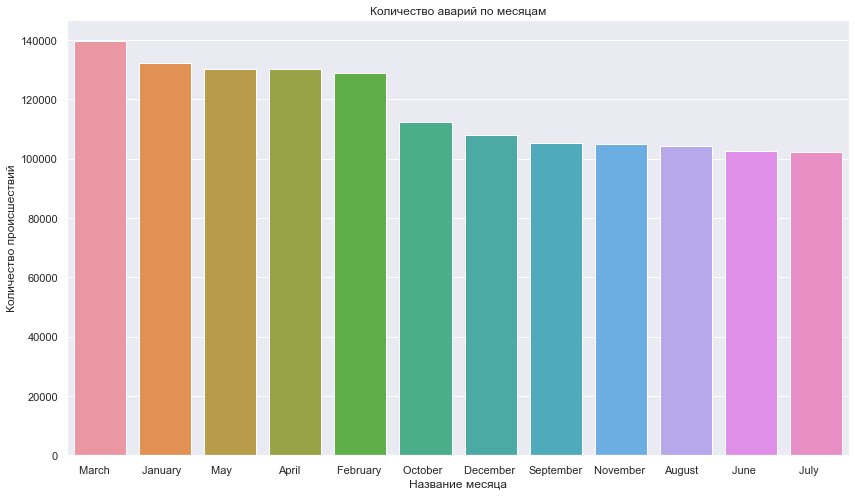

In [173]:
plot_bar_stat(search, 'month_name', 'count_accidents', 'Количество аварий по месяцам', 'Название месяца', 
              'Количество происшествий')

Наибольшее количество аварий за все время произошло в Марте, меньше всего происходило летом. Удивительно, конечно, все таки летом любят дрифтить, что по идеи должно приводить к авариям.

In [22]:
query = '''
SELECT TO_CHAR(collision_date, 'Month') month_name,
       TO_CHAR(collision_date, 'yyyy') year_name, 
       COUNT(*) count_accidents
       
FROM collisions
GROUP BY month_name, year_name
ORDER BY count_accidents DESC;
'''

search_two = pd.read_sql_query(query, con=engine) 

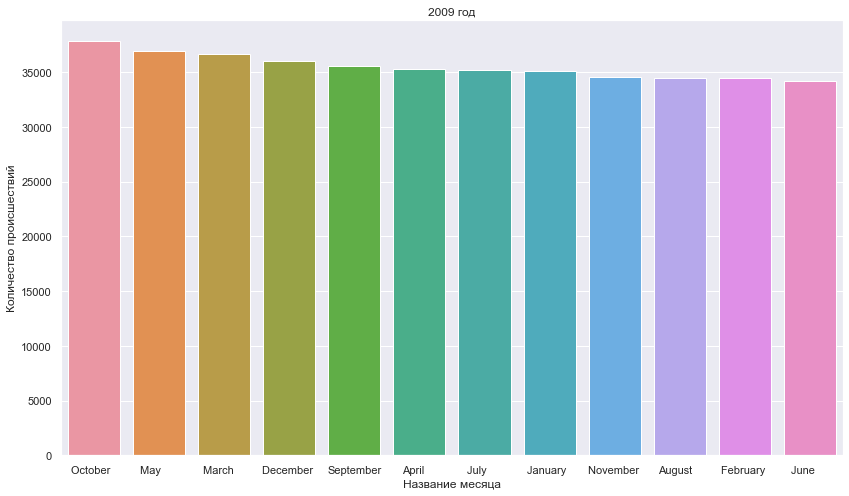

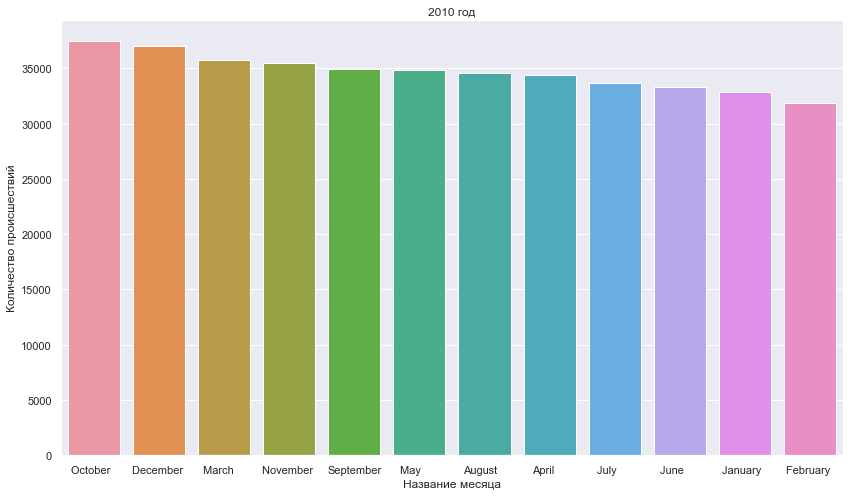

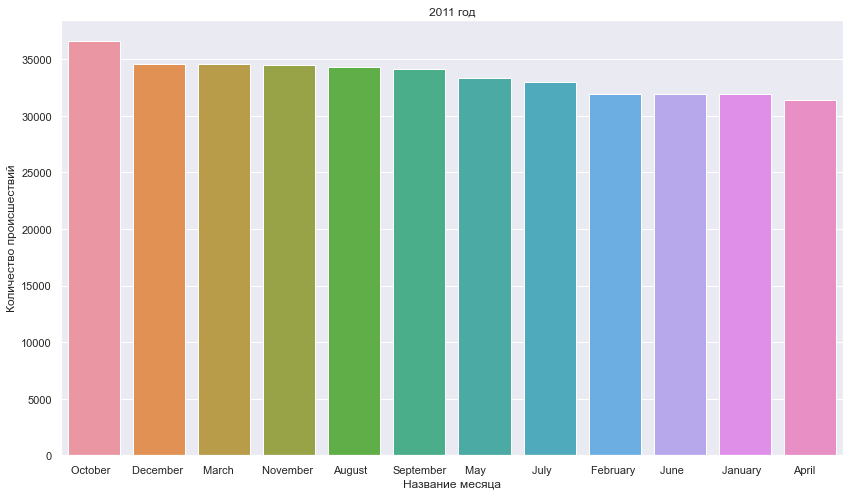

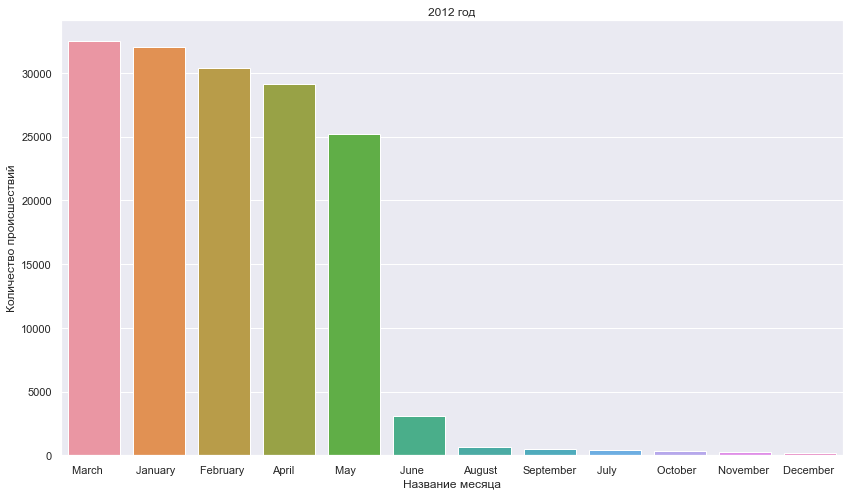

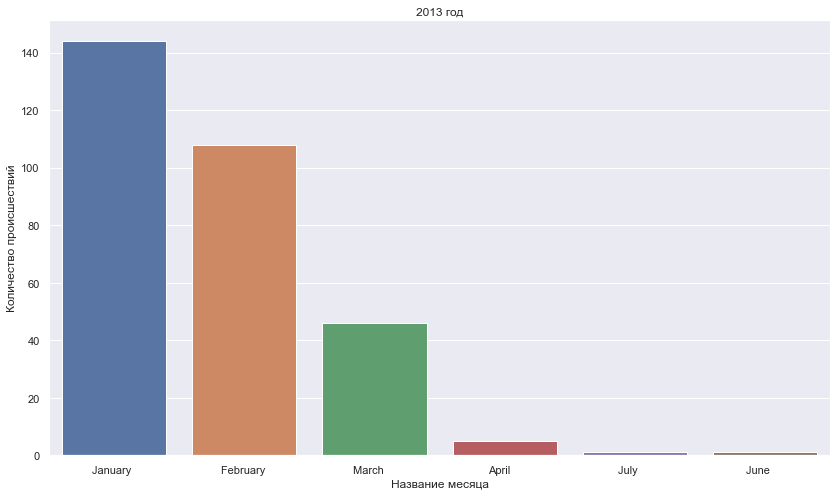

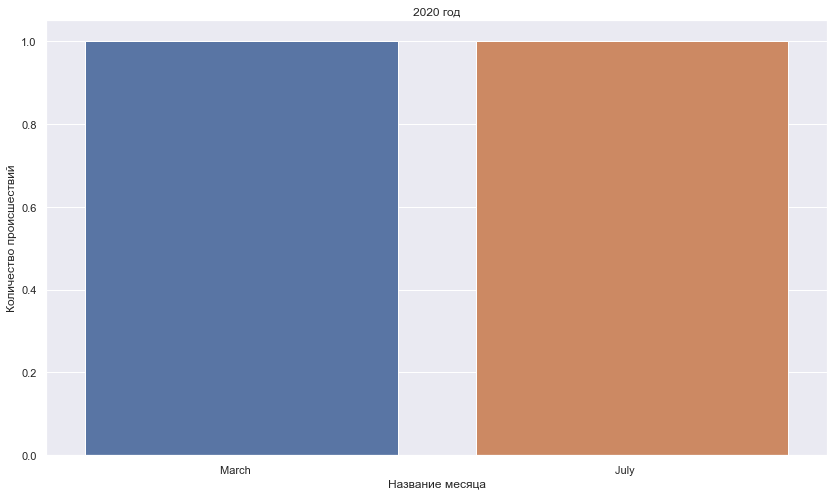

In [175]:
for year in search_two['year_name'].unique():
    plot_bar_stat(df=search_two[search_two['year_name'] == year], x='month_name', y='count_accidents', 
                  title= year+' год', xlabel='Название месяца', ylabel='Количество происшествий')

Если смотреть более глубже, то получается так, что за 2009 год больше всего аварий происходило в Октябре, за 2010 год также в Октябре, за 2011 год в Октябре, за 2012 год в Марте, а дальше данных слишком мало. 

**Вывод** Больше всего аварий происходит в Октябре, на общем графике показан Март, т.к. в 2012 нет данных за октябрь, либо их очень очень мало.

**Аналитические задачи:**

- `Провести анализ состояния человека в момент аварий`
- `Проверить зависимость виновности от суммы страховки` -  т.е. чем больше страховка, тем меньше вероятность быть виновным.
- `Проверить зависимость возможности разговаривать по громкой связи и серьезности дтп`
- `Найти самые частые типы дорог, на которых было ДТП` 
- `Найти среднее количество аварий в день в зависимости от погоды`
- `Провести анализ серьезности дтп исходя из погоды`
- `Провести анализ того, насколько уменьшались/увеличивались аварии в топ 20 городах` 
- `Провести анализ серьёзности происшествия исходя из трезвости водителя`
- `Провести анализ нарушений в зависимости от типа дороги, т.е. понять, из-за чего происходят все эти аварии на шоссе и т.д., т.к. аварии в большинстве случае происходят в ясную погоду` 
- `Выяснить в какое время происходит большее количество аварий`
- `Провести анализ состояния водителей во времмя дтп в топ 20 городов`
- `Найти города с самым большим количеством аварий`
- `Проанализировать серьезность дтп исходя из состояния дороги`




**Провести анализ состояния трезвости в момент аварии**

In [30]:
query = '''
SELECT party_sobriety,
       ROUND(count / (SUM(count) OVER()) * 100)::int probability
FROM
    (SELECT p.party_sobriety,
            COUNT(*)
     FROM collisions c
     INNER JOIN parties p ON c.case_id = p.case_id
     WHERE p.party_type = 'car'
     GROUP BY p.party_sobriety
     ORDER BY COUNT(*) DESC) df;
'''

df = pd.read_sql_query(query, con=engine)
df

,party_sobriety,probability
0,had not been drinking,82
1,impairment unknown,9
2,"had been drinking, under influence",4
3,None,2
4,not applicable,1
5,"had been drinking, impairment unknown",1
6,"had been drinking, not under influence",1


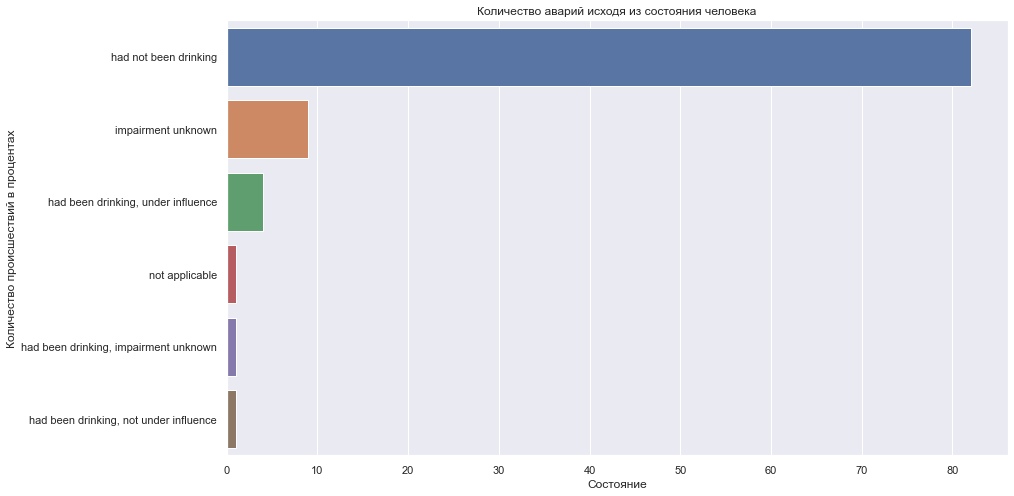

In [202]:
plot_bar_stat(df, 'probability', 'party_sobriety', 'Количество аварий исходя из состояния человека', 'Состояние', 
              'Количество происшествий в процентах')

Большинство людей в авариях трезвые, следовательно, аварии происходят либо из-за того, что не справиляются с управлением(погодные условия), либо же из-за каких-то ошибок(при повороте налево).

**Провести анализ серьёзности происшествия исходя из трезвости водителя.**

In [196]:
query = '''
SELECT party_sobriety,
       collision_damage,
       ROUND(count / (SUM(count) OVER()) * 100, 2) probability
FROM
    (SELECT p.party_sobriety,
            c.collision_damage,
            COUNT(*)
     FROM collisions c
     LEFT JOIN parties p ON c.case_id = p.case_id
     WHERE party_type = 'car'
     GROUP BY p.party_sobriety, c.collision_damage
     ORDER BY COUNT(*) DESC) df;
'''

df = pd.read_sql_query(query, con=engine) 
df

,party_sobriety,collision_damage,probability
0,had not been drinking,small damage,47.37
1,had not been drinking,scratch,24.50
2,had not been drinking,middle damage,8.67
3,impairment unknown,small damage,7.09
4,"had been drinking, under influence",small damage,2.57
5,had not been drinking,severe damage,1.35
6,impairment unknown,scratch,1.33
7,None,small damage,1.07
8,"had been drinking, under influence",middle damage,0.84
9,"had been drinking, under influence",scratch,0.64


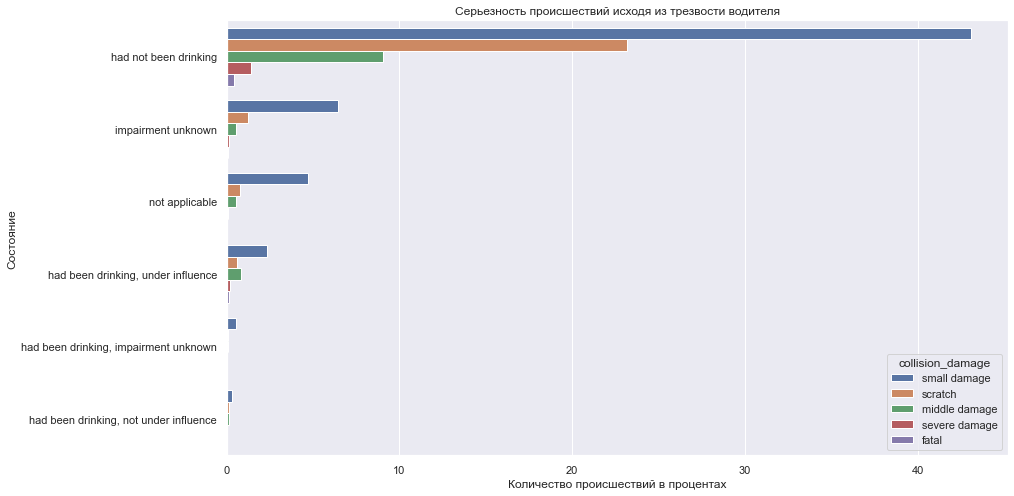

In [185]:
plot_bar_stat(df, x='probability', y='party_sobriety', hue='collision_damage', 
              title='Серьезность происшествий исходя из трезвости водителя', 
              ylabel='Состояние',  xlabel='Количество происшествий в процентах')

Во всех происшествиях по большей части люди, которые не пили, в этих происшествиях машина имела по большей части маленький удар, либо же царапину, серьезных дтп было мало. В целом преимущественно в дтп были маленйшие повреждения у всех водителей.

**Провести анализ состояния человека в момент аварий**

In [206]:
query = '''
SELECT party_drug_physical,
       ROUND(count / (SUM(count) OVER()) * 100, 2) probability
FROM
    (SELECT party_drug_physical,
            COUNT(*)
     FROM parties
     WHERE party_type = 'car'
     GROUP BY party_drug_physical
     ORDER BY COUNT(*) DESC) df;
'''

df = pd.read_sql_query(query, con=engine) 
df

,party_drug_physical,probability
0,None,88.74
1,G,9.12
2,not applicable,0.97
3,sleepy/fatigued,0.51
4,under drug influence,0.50
5,impairment - physical,0.16


In [207]:
df.loc[1, 'party_drug_physical'] = 'impairment unknown'
df.loc[0, 'party_drug_physical'] = 'not stated'

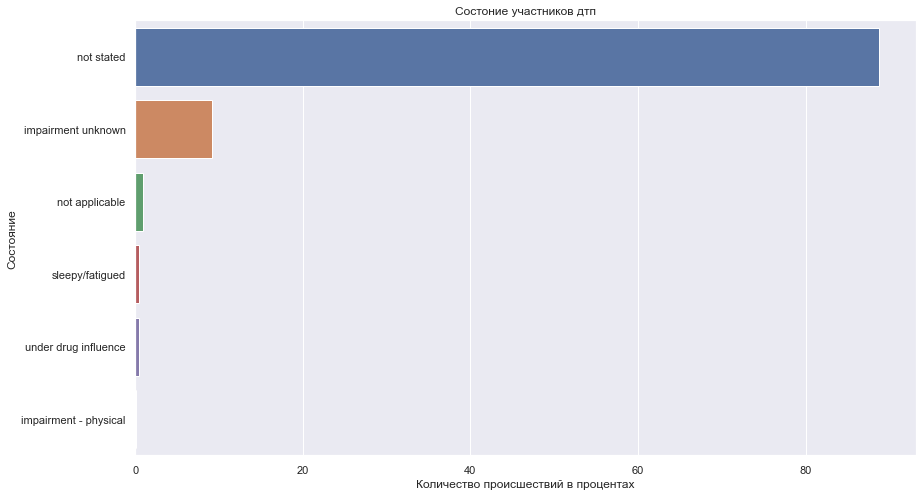

In [208]:
plot_bar_stat(df, x='probability', y='party_drug_physical',title='Состоние участников дтп', 
              ylabel='Состояние',  xlabel='Количество происшествий в процентах')

В большинстве случаев не указано состояние тех, кто участвовал в дтп. Также много неизвестно и не оценивалось...

**Серьезность дтп исходя из состояния дороги** 

In [210]:
query = '''
SELECT road_surface,
       collision_damage,
       ROUND(count / (SUM(count) OVER()) * 100, 2) probability
FROM
    (SELECT road_surface,
            collision_damage,
            COUNT(*)
     FROM collisions
     GROUP BY road_surface, collision_damage
     ORDER BY COUNT(*) DESC) df;
'''

df = pd.read_sql_query(query, con=engine) 
df.loc[[20, 21, 22,23 ,24], 'road_surface'] = 'not stated'
df

,road_surface,collision_damage,probability
0,dry,small damage,53.24
1,dry,scratch,22.00
2,dry,middle damage,10.79
3,wet,small damage,6.17
4,wet,scratch,2.38
5,dry,severe damage,1.99
6,wet,middle damage,0.94
7,dry,fatal,0.70
8,None,small damage,0.58
9,snowy,small damage,0.36


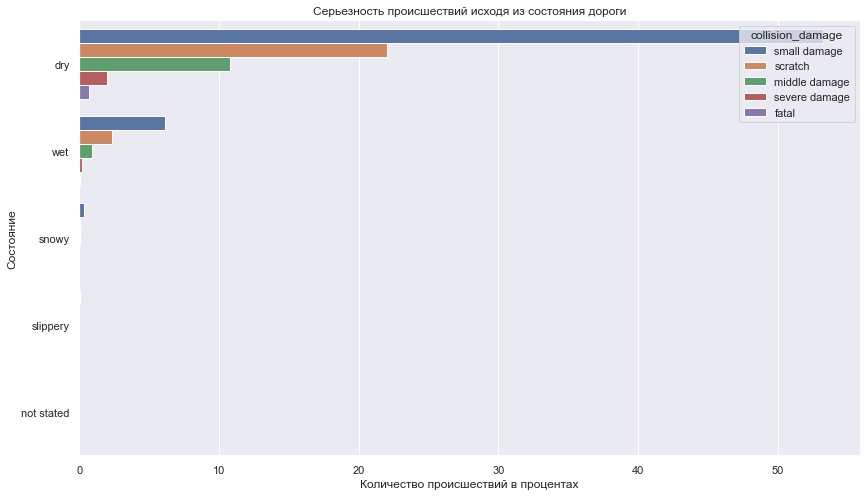

In [211]:
plot_bar_stat(df, x='probability', y='road_surface', hue='collision_damage', 
              title='Серьезность происшествий исходя из состояния дороги', 
              ylabel='Состояние',  xlabel='Количество происшествий в процентах')

Большая часть аварий происходила на сухой дороге, что также подтверждает то, что дтп происходили из-за ошибок водителя. На мокрой дороге происходили дтп, но не так много. Во всех этих авариях в большой части были незначительные повреждения.

**Топ-20 городов, в которых произошли аварии с процентом аварий** 

In [214]:
query = '''
SELECT county_location,
       ROUND(count / (SUM(count) OVER()) * 100, 2) probability
FROM
    (SELECT county_location,
            COUNT(*)
     FROM collisions
     GROUP BY county_location
     ORDER BY COUNT(*) DESC
     LIMIT 20) df;
'''

df = pd.read_sql_query(query, con=engine)
df

,county_location,probability
0,los angeles,35.05
1,orange,9.56
2,san bernardino,6.41
3,san diego,6.33
4,riverside,5.60
5,alameda,5.22
6,sacramento,4.61
7,santa clara,4.10
8,ventura,2.61
9,contra costa,2.54


Больше всего аварий произошло в los angeles, больше трети всех аварий

In [215]:
city_name = df['county_location'].unique()

Топ 20 городов, где происходили дтп

**Провести анализ состояния водителей во времмя дтп в топ 20 городов** 

In [217]:
query = '''
SELECT county_location,
       party_sobriety,
       ROUND(count / (SUM(count) OVER()) * 100, 2) probability
FROM
    (SELECT county_location,
            party_sobriety,
            COUNT(*)
     FROM collisions c
     LEFT JOIN parties p ON c.case_id = p.case_id
     WHERE county_location IN (SELECT county_location
                               FROM collisions
                               GROUP BY county_location
                               ORDER BY COUNT(*) DESC
                               LIMIT 20)
       AND party_type = 'car'
     GROUP BY county_location, party_sobriety
     ORDER BY COUNT(*) DESC) df;
'''

df = pd.read_sql_query(query, con=engine)
df  

,county_location,party_sobriety,probability
0,los angeles,had not been drinking,28.98
1,orange,had not been drinking,8.56
2,san bernardino,had not been drinking,5.37
3,san diego,had not been drinking,5.15
4,riverside,had not been drinking,4.66
...,...,...,...
135,sonoma,"had been drinking, impairment unknown",0.01
136,monterey,"had been drinking, not under influence",0.01
137,tulare,"had been drinking, not under influence",0.01
138,sonoma,not applicable,0.01


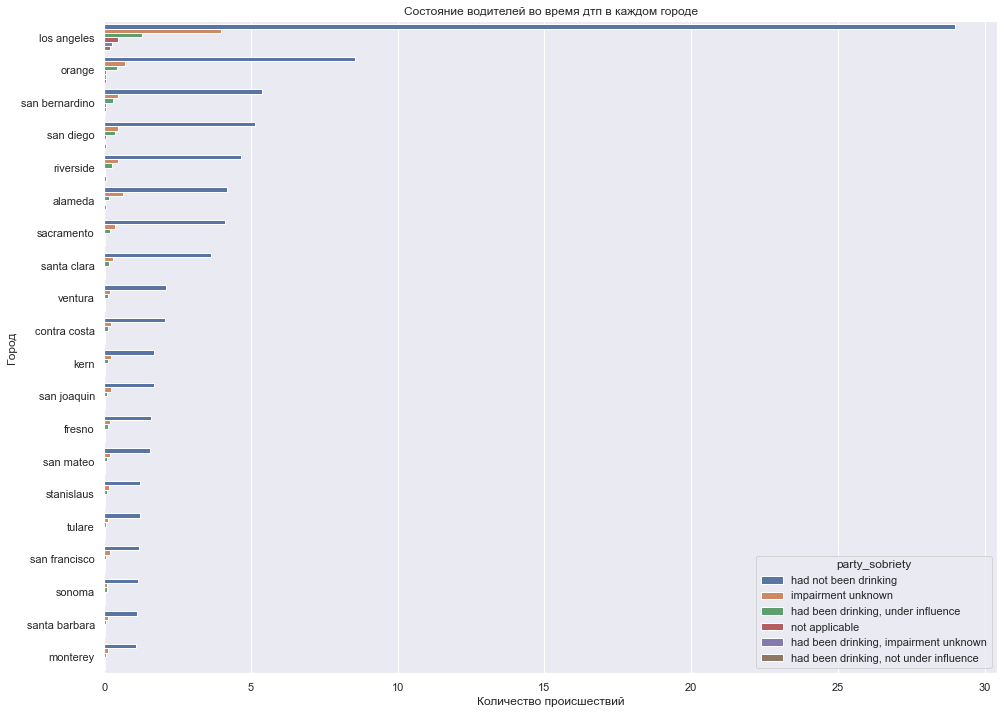

In [220]:
plt.figure(figsize=(16, 12))
sns.barplot(data=df, x='probability', y='county_location', hue='party_sobriety');
plt.xlabel('Количество происшествий');
plt.ylabel('Город');
plt.title('Состояние водителей во время дтп в каждом городе');

Те аварии, где есть те, кто выпили и находятся под чем-то, в в большей мере находятся все в Лос-Анджелесе, в остальных городаъ их не так много. Также можно сказать, что вообще не так много аварий произошло с участием пьющих людей, что может говорить о хорошей работе полиции.

**Выяснить в какое время происходит большее количество аварий**

In [222]:
query = '''
SELECT time,
       ROUND(count / (SUM(count) OVER()) * 100, 2) probability
FROM
    (SELECT TO_CHAR(collision_time, 'HH24') as time,
            COUNT(*)
     FROM collisions
     GROUP BY TO_CHAR(collision_time, 'HH24')) df;
'''

df = pd.read_sql_query(query, con=engine)
df  

,time,probability
0,00,1.89
1,01,1.90
2,02,2.02
3,03,1.31
4,04,1.09
5,05,1.44
6,06,2.41
7,07,5.10
8,08,5.35
9,09,4.21


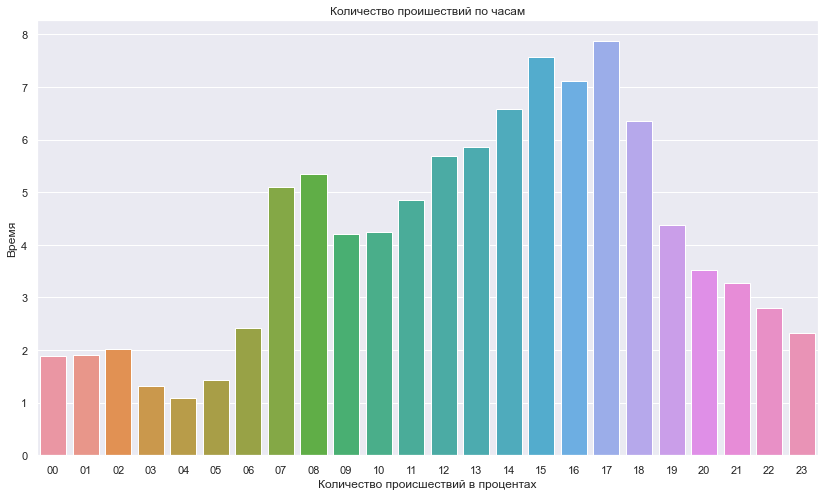

In [225]:
plot_bar_stat(df, x='time', y='probability', title='Количество проишествий по часам', 
              ylabel='Время',  xlabel='Количество происшествий в процентах')

Больше всего аварий происходит во время обеда и окончания раб. дня, как я понимаю, т.е. 14-18:00(около 7-8 процентов от всех аварий)

**Среднее количество аварий в день на различных дорогах** 

In [42]:
query = '''
SELECT DISTINCT
       location_type,
       ROUND(AVG(count_dtp) OVER(PARTITION BY location_type)) avg_dtp
FROM
    (SELECT location_type,
            DATE_TRUNC('DAY', collision_date)::date date_name,
            COUNT(*) count_dtp
    FROM collisions
    GROUP BY location_type, date_name) data_count
ORDER BY avg_dtp;
'''

df = pd.read_sql_query(query, con=engine)
df  

,location_type,avg_dtp
0,intersection,20.0
1,ramp,56.0
2,highway,278.0
3,None,572.0


In [43]:
df['avg_dtp'].sum()

926.0

В среднем, в день происходит на шоссе в среднем 278 аварии, на перекрестках 20 аварий, на рампах 56 аварий. На счет тех, что не указаны смысла нет говорить, т.к. там может быть разные типы дорог. В сумме в день происходит 926 аварий.

**Среднее количество аварий в день в зависимости от погоды** 

In [227]:
query = '''
SELECT DISTINCT
       weather_1,
       ROUND(AVG(count_dtp) OVER(PARTITION BY weather_1)) avg_dtp
FROM
    (SELECT weather_1,
            DATE_TRUNC('DAY', collision_date)::date date_name,
            COUNT(*) count_dtp
    FROM collisions
    GROUP BY weather_1, date_name) data_count
ORDER BY avg_dtp DESC;
'''

df = pd.read_sql_query(query, con=engine)
df  

,weather_1,avg_dtp
0,clear,728.0
1,cloudy,145.0
2,raining,62.0
3,fog,7.0
4,None,6.0
5,snowing,6.0
6,wind,2.0
7,other,2.0


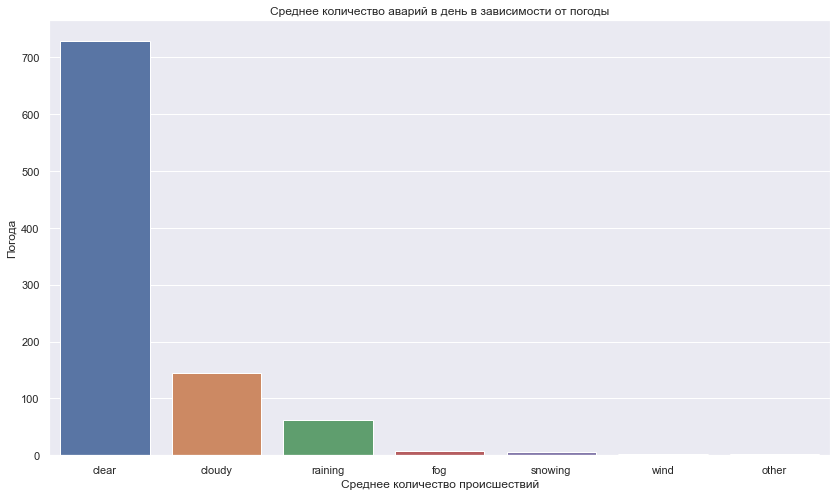

In [228]:
plot_bar_stat(df, x='weather_1', y='avg_dtp', title='Среднее количество аварий в день в зависимости от погоды', 
              ylabel='Погода',  xlabel='Среднее количество происшествий')

Большинство аварий происходит в ясную погогу, после в облочную, а потом в дожди. Удивительно, конечно. Нужно проверить типы повреждений исходя из погоды. Предполагаю, что в ясную погоду повреждения машины незначительные, а в дождливую более серьезней.

**Провести анализ серьезности дтп исходя из погоды** 

In [229]:
query = '''
SELECT weather_1,
       collision_damage,
       ROUND(count / (SUM(count) OVER()) * 100, 2) probability
FROM
    (SELECT weather_1,
           collision_damage,
           COUNT(*)
    FROM collisions
    GROUP BY weather_1, collision_damage
    ORDER BY COUNT(*) DESC) df;
'''

df = pd.read_sql_query(query, con=engine) 
df

,weather_1,collision_damage,probability
0,clear,small damage,47.97
1,clear,scratch,19.88
2,clear,middle damage,9.79
3,cloudy,small damage,9.00
4,cloudy,scratch,3.52
5,raining,small damage,2.60
6,clear,severe damage,1.81
7,cloudy,middle damage,1.58
8,raining,scratch,1.05
9,clear,fatal,0.62


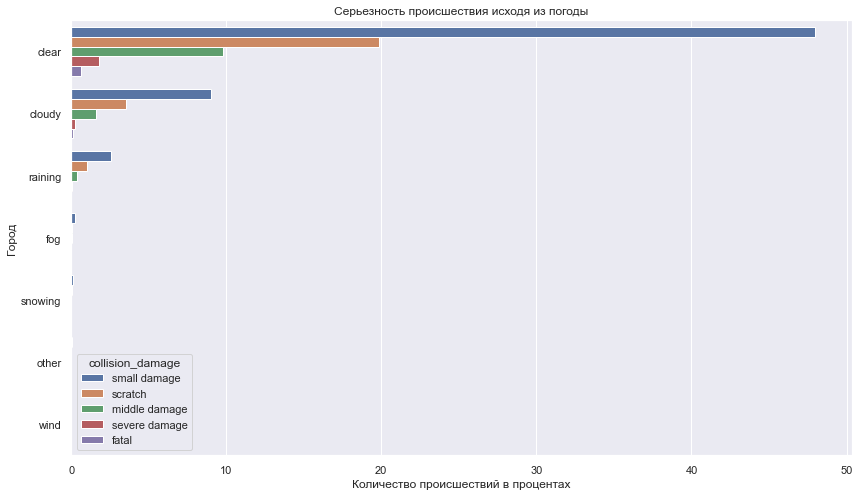

In [233]:
plot_bar_stat(df, x='probability', y='weather_1', hue='collision_damage', title='Серьезность происшествия исходя из погоды', 
              ylabel='Город',  xlabel='Количество происшествий в процентах')

Не подлежащих ремонту дтп происходили по большей части в ясную погоду, а в дождливую вообще нет. Будто бы в среднем в за эти годы очень мало таких дней было с плохой погодой...

**Идея** Проверить то, насколько в каждом году было больше/меньше дтп, исключить года после 2012 включительно, т.к. 2012 год не все месяцы данные. 

Также можно посмотреть то, насколько меньше/больше дтп становилось с каждым годом в топ 20 городах.

In [48]:
query = '''
SELECT name_year,
       count_dtp,
       ROUND(((count_dtp - LAG(count_dtp) OVER(ORDER BY name_year))::numeric / LAG(count_dtp) OVER(ORDER BY name_year)) * 100, 2) percentage
FROM
    (SELECT DISTINCT
            TO_CHAR(collision_date, 'yyyy') name_year,
            COUNT(*) OVER(PARTITION BY TO_CHAR(collision_date, 'yyyy')) count_dtp
    FROM collisions
    WHERE TO_CHAR(collision_date, 'yyyy') BETWEEN '2009' AND '2011'
    ORDER BY name_year) df_year_count;
'''

df = pd.read_sql_query(query, con=engine) 
df

,name_year,count_dtp,percentage
0,2009,426228,NaN
1,2010,416490,-2.28
2,2011,402428,-3.38


С каждым годом количество аварий уменьшалось

**Анализ того, насколько уменьшались/увеличивались аварии в топ 20 городах** 

In [49]:
query = '''
WITH count_dtp_year_city as
    (SELECT DISTINCT
            county_location,
            TO_CHAR(collision_date, 'yyyy') name_year,
            COUNT(*) OVER(PARTITION BY county_location, TO_CHAR(collision_date, 'yyyy')) count_dtp
     FROM collisions
     WHERE county_location IN (SELECT county_location
                               FROM collisions
                               GROUP BY county_location
                               ORDER BY COUNT(*) DESC
                               LIMIT 20)
       AND TO_CHAR(collision_date, 'yyyy') BETWEEN '2009' AND '2011')
                              
SELECT county_location,
       name_year,
       count_dtp,
       ROUND(((count_dtp - LAG(count_dtp) OVER(PARTITION BY county_location ORDER BY name_year))::numeric / LAG(count_dtp) OVER(PARTITION BY county_location ORDER BY name_year)) * 100, 2) percentage
FROM count_dtp_year_city
'''

df = pd.read_sql_query(query, con=engine) 
df

,county_location,name_year,count_dtp,percentage
0,alameda,2009,20604,NaN
1,alameda,2010,19316,-6.25
2,alameda,2011,18317,-5.17
3,contra costa,2009,9956,NaN
4,contra costa,2010,9138,-8.22
5,contra costa,2011,9041,-1.06
6,fresno,2009,8082,NaN
7,fresno,2010,7933,-1.84
8,fresno,2011,8075,1.79
9,kern,2009,8573,NaN


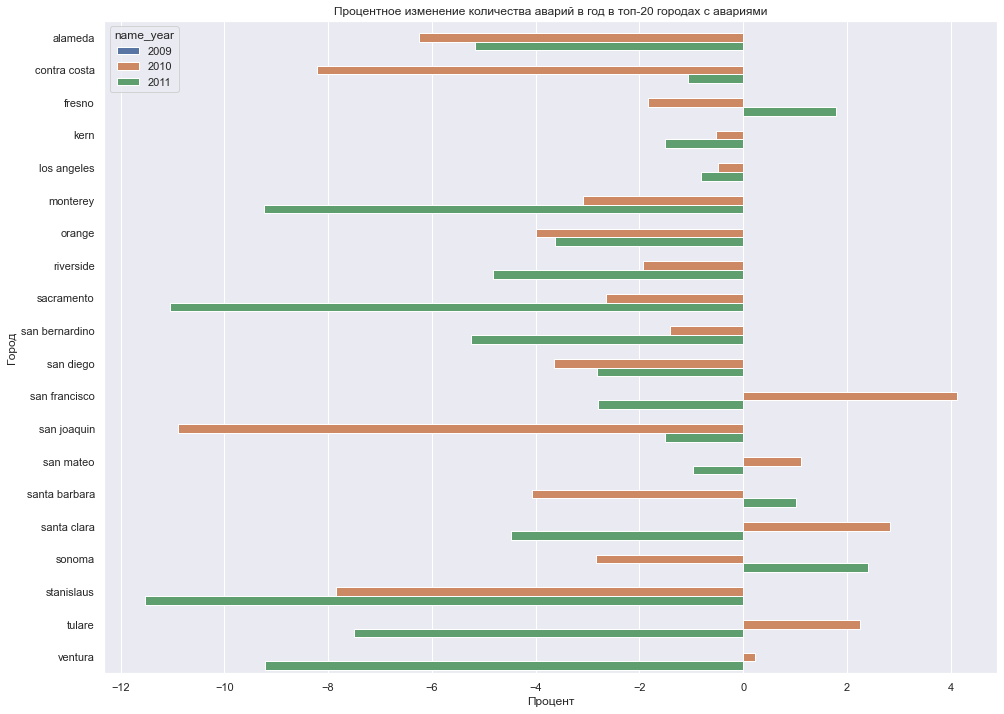

In [50]:
plt.figure(figsize=(16, 12))
sns.barplot(data=df, x='percentage', y='county_location', hue='name_year');
plt.xlabel('Процент');
plt.ylabel('Город');
plt.title('Процентное изменение количества аварий в год в топ-20 городах с авариями');

В городах с каждым годом количество аварий уменьшалось, за исключением нескольких годов в некоторых городах.

**Нарушение в зависимости от типа дороги, т.е. понять, из-за чего происходят все эти аварии на шоссе и т.д., т.к. аварии в большинстве случае происходят в ясную погоду**

In [234]:
query = '''
SELECT location_type,
       pcf_violation_category,
       ROUND(count / (SUM(count) OVER()) * 100, 2) probability
FROM
    (SELECT DISTINCT
           location_type,
           pcf_violation_category,
           COUNT(*) OVER(PARTITION BY location_type, pcf_violation_category ORDER BY location_type, pcf_violation_category)
    FROM collisions
    ORDER BY location_type, pcf_violation_category) df
'''

df = pd.read_sql_query(query, con=engine) 
df = df.fillna('not stated')
df

,location_type,pcf_violation_category,probability
0,highway,automobile right of way,0.30
1,highway,brakes,0.00
2,highway,dui,1.82
3,highway,fell asleep,0.00
4,highway,following too closely,0.63
...,...,...,...
89,not stated,unknown,2.34
90,not stated,unsafe lane change,2.03
91,not stated,unsafe starting or backing,3.41
92,not stated,wrong side of road,2.01


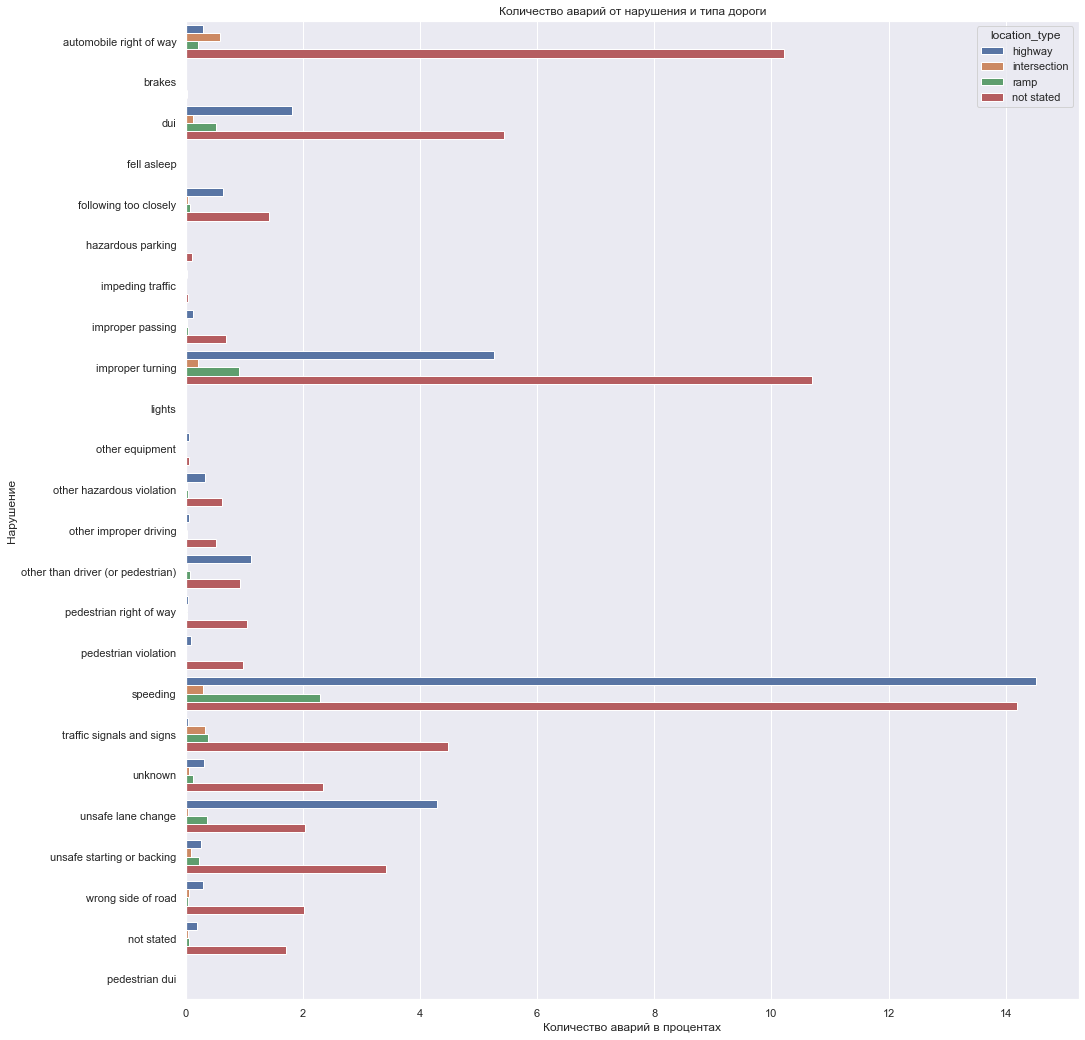

In [236]:
plt.figure(figsize=(16, 18))
sns.barplot(data=df, x='probability', y='pcf_violation_category', hue='location_type');
plt.xlabel('Количество аварий в процентах');
plt.ylabel('Нарушение');
plt.title('Количество аварий от нарушения и типа дороги');

На шоссе по большей части аварии из-за превышения скорости, неправильного поворота, небезопасной смены полосы движения, т.е. невнимательности водителя.

# Модель для оценки

In [27]:
query = '''
SELECT c.county_location,
       EXTRACT(month FROM c.collision_date) month_name,
       p.insurance_premium,
       p.party_drug_physical,
       p.cellphone_in_use,
       v.vehicle_type,
       v.vehicle_transmission,
       v.vehicle_age,
       c.direction,
       p.at_fault
FROM collisions c
LEFT JOIN parties p ON c.case_id = p.case_id
INNER JOIN vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car'
  AND NOT c.collision_damage = 'scratch'
  AND TO_CHAR(c.collision_date, 'yyyy') = '2012';
'''

data = pd.read_sql_query(query, con=engine) 
data.head()

,county_location,month_name,insurance_premium,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,direction,at_fault
0,los angeles,4.0,46.0,None,0.0,sedan,auto,2.0,south,0
1,san mateo,5.0,38.0,None,0.0,sedan,auto,5.0,east,1
2,ventura,4.0,NaN,G,0.0,sedan,auto,NaN,north,0
3,san bernardino,4.0,43.0,None,0.0,sedan,auto,8.0,north,1
4,nevada,4.0,38.0,None,0.0,sedan,auto,6.0,east,1


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_location       56248 non-null  object 
 1   month_name            56248 non-null  float64
 2   insurance_premium     55701 non-null  float64
 3   party_drug_physical   2857 non-null   object 
 4   cellphone_in_use      51777 non-null  float64
 5   vehicle_type          56248 non-null  object 
 6   vehicle_transmission  55389 non-null  object 
 7   vehicle_age           54554 non-null  float64
 8   direction             43230 non-null  object 
 9   at_fault              56248 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 4.3+ MB


- `case_id` - просто id аварии, который не несет в себе никакой информации
- `county_city_location` - есть аналог county_location, который я буду использовать


Сразу опишу заранее то, из-за чего удаляется так много признаков. К нам приходит клиент, на каких основаниях можно оценить то, можно ли дать ему машину или нет? У нас имеется только информация о машине, о клиенте, а также о маршруте. Маршрут - вектор, который можно разделить на координаты, которых у нас нет, и по ним предсказывать вероятности того, попадет ли клиент в каком-то месте в аварию или нет(допустим, на каком-то участке, координате, будет вероятность 80 процентов дтп, в итоге машину не выдаем). У нас в данных нет информации координат, точнее есть, но их недостаточно.


То, как я вижу данную задачу с такими данными... Мы можем на основе состояния человека попробовать предсказать может ли он попасть в дтп, т.е. при плохом самочувствии больше вероятность попасть в дтп, чем при нормальном. Почему я не беру county_city_location, т.е. с помощью района, дистанции от главной дороги, а также направления теоретически можно предсказать вероятность дтп, но не так все легко. В данных у нас 1 строчка, в которых нет информации о каждом моменте времени езды на автомобиле, т.е. он может ехать по 1 дороге, потом по другой, а в данных такой информации нет, т.е. может быть информация только по 1 району, а нужна ли такая инфомарция вообще? Считаю, что нет, желательно получить информацию по каждой дороге, по которой он едет. Нужен граф, который будет описывать маршрут, ребра - дороги, который также можно описать(состояния, освещение и т.д.) и с помощью этого уже делать нормальную систему оценки.


- `distance` - возможно, странно, что удаляю, но дистанция в себе не несет никакой информации, если она одна. Вместе с направлением она несет какую-то информацию, но мешает то, что это расстояние от главной дороги. Она же не может быть одна на весь город, следовательно, мы точно не знаем от какой главной дороги. 
- `intersection` - точно не знаем какой перекресток.
- `weather_1` - здесь будто бы временная серия, т.е. во время сдачи машины все хорошо с погодой, а потом хуже и уже другая вероятность получается попасть в дтп.
- `location_type` - тоже самое, что и раньше, нет координат, чтобы четко понимать, на какой локации будет ехать клиент.
- `collision_damage` - это как даталик, что смотрим в будущее, следовательно, удаляем
- `party_count` - количество пострадавших точно не нужен, это будущее
- `primary_collision_factor` - также будущее
- `pcf_violation_category` - категорию нарушения можно было бы использовать вместе с координатами, т.е. в каких-то местах любят нарушать, следовательно, больше риск аварии, но т.к. координат нет, то удаляю
- `type_of_collision` - это заглядывание в будущее, только если использовать как вероятность того, что на каком-то участке может быть авария лоб в лоб и т.д., но нужны координаты
- `motor_vehicle_involved_with` - заглядывание в будущее
- `road_surface` - либо оставить, либо нет - оставить, т.к. на момент выдачи авто это можно посмотреть, но вот, допустим, выдали авто в ясную погоду, а через 10 минут пошёл дождь, в итоге дорога стала мокрой. Это ведь может повлиять на дтп, в итоге этот признак несет в себе не точную информацию
- `road_condition_1` - без координат  этот признак не несет в себе информацию.
- `lighting` - зависит от локацию, которые мы не можем распознать, т.к. нет координат
- `control_device` - если я правильно понимаю суть этого признака, то это также будущее(т.е. состояние после аварии)
- `collision_time` - было бы интересно совместить это с разными участками аварий, если бы можно было найти эти участки, а так для я оставляю признак даты
- `id` - обычный id
- `party_number` - номер пострадавшего - будущее
- `party_type` - используем только car
- `party_sobriety` - интересно тут, конечно, получается. Есть человек, который под чем-то + не очень трезвый, дадут ли ему в прокат машину? Нет. А для чего нужен тогда этот признак, если у нас получится так, что человек не трезвый, а ему дали машину. Человек мог выпить после того, как арендовал автомобиль, в итоге данные с сильным шумом по данному признаку получатся.

In [29]:
for column in data.columns:
    print(f'Количество пропусков в столбце {column}: {data[data[column].isna()].shape[0]}')

Количество пропусков в столбце county_location: 0
Количество пропусков в столбце month_name: 0
Количество пропусков в столбце insurance_premium: 547
Количество пропусков в столбце party_drug_physical: 53391
Количество пропусков в столбце cellphone_in_use: 4471
Количество пропусков в столбце vehicle_type: 0
Количество пропусков в столбце vehicle_transmission: 859
Количество пропусков в столбце vehicle_age: 1694
Количество пропусков в столбце direction: 13018
Количество пропусков в столбце at_fault: 0


In [30]:
data['party_drug_physical'] = data['party_drug_physical'].apply(lambda x: 'impairment unknow' if x == 'G' else x)
data['party_drug_physical'] = data['party_drug_physical'].fillna('not_stated')

In [31]:
data['cellphone_in_use'] = data['cellphone_in_use'].fillna(2)
data['cellphone_in_use'] = data['cellphone_in_use'].apply(
    lambda x: 'no' if x == 0 else 'yes' if x == 1 else 'unknow')

In [32]:
data['vehicle_transmission'] = data['vehicle_transmission'].fillna('not_specified')

In [33]:
data['direction'] = data['direction'].fillna('UNK')

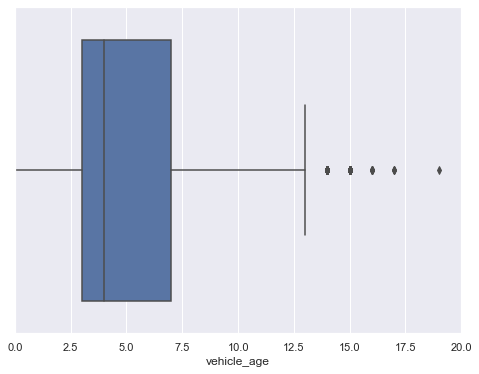

In [34]:
plt.figure(figsize=(8, 6));
sns.boxplot(x=data['vehicle_age']);
plt.xlim(0, 20);

In [35]:
data[data['vehicle_age'] > 14].shape

(49, 10)

In [36]:
data = data.drop(data[data['vehicle_age'] > 14].index)

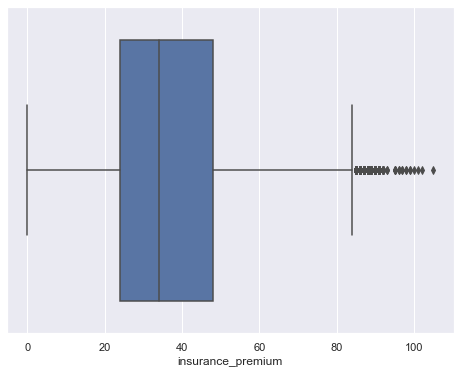

In [37]:
plt.figure(figsize=(8, 6));
sns.boxplot(x=data['insurance_premium']);

In [38]:
data[data['insurance_premium'] > 85].shape

(279, 10)

In [39]:
data = data.drop(data[data['insurance_premium'] > 85].index)

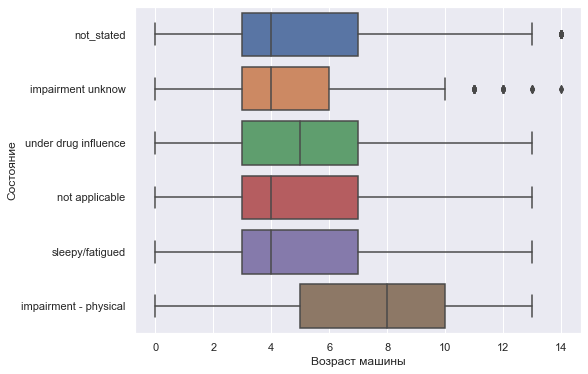

In [40]:
plt.figure(figsize=(8, 6));
sns.boxplot(x=data['vehicle_age'], y=data['party_drug_physical']);
plt.xlabel('Возраст машины');
plt.ylabel('Состояние');

Интересно, что людям, которые плохо себя чуствуют, получали машины с более высоким годом, относительно других категорий состояния людей.

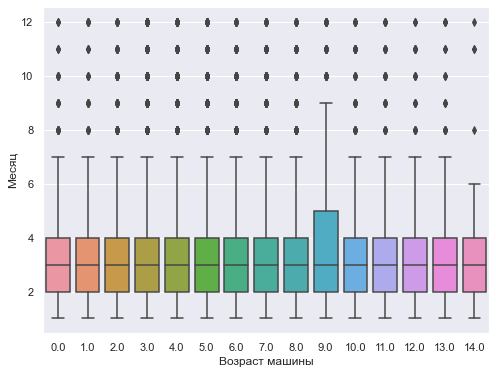

In [41]:
plt.figure(figsize=(8, 6));
sns.boxplot(x=data['vehicle_age'], y=data['month_name']);
plt.xlabel('Возраст машины');
plt.ylabel('Месяц');

Каждый месяц людям дают равные по возрасту машины, т.е. нет такого, что в какой-то сезон машины с высоким возрастом, а в какой-то с низким.

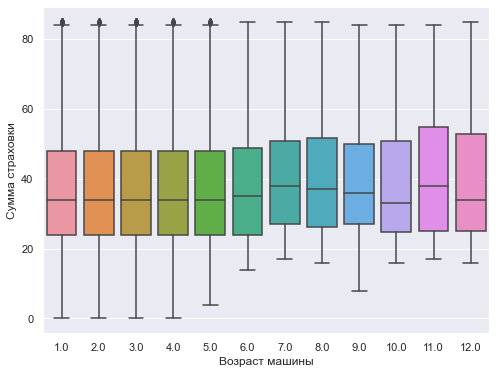

In [42]:
plt.figure(figsize=(8, 6));
sns.boxplot(x=data['month_name'], y=data['insurance_premium']);
plt.xlabel('Возраст машины');
plt.ylabel('Сумма страховки');

Большая часть машин одинаковые по страховке в каждом месяца, но вот зимой и летом нижняя граница страховки выше, чем в остальные сезоны. Возможно, это связано с тем, что данных не все, а точнее не по всем месяцам, вот так и получается.

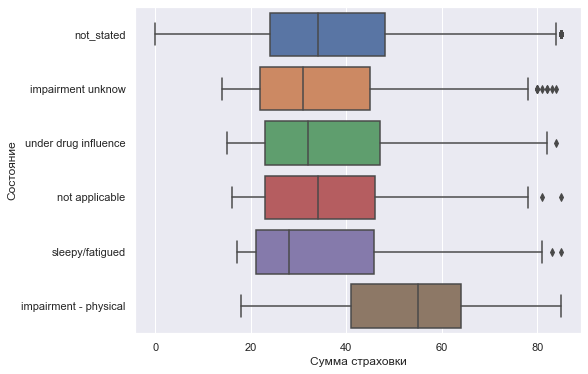

In [43]:
plt.figure(figsize=(8, 6));
sns.boxplot(x=data['insurance_premium'], y=data['party_drug_physical']);
plt.xlabel('Сумма страховки');
plt.ylabel('Состояние');

С состоянием получается также, как было выше, т.е. тем, кто плохо себя чувствует, машина с более дорогой страховкой. Возможно, те машины, у которых больше возраст, больше и сраховка

Text(0, 0.5, 'Возраст машины')

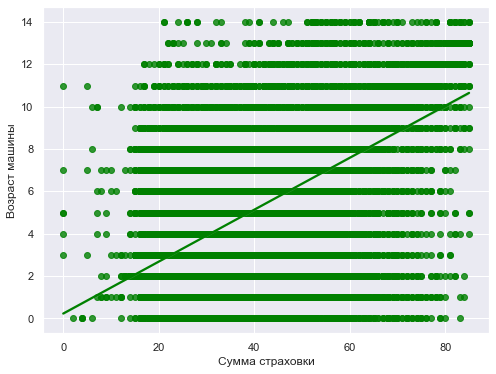

In [44]:
plt.figure(figsize=(8, 6))
sns.regplot(x=data['insurance_premium'], y=data['vehicle_age'], color='green');
plt.xlabel('Сумма страховки')
plt.ylabel('Возраст машины')

Да, у машин с большим возрастом, больше страховка. Удивительно, что у более старых машин дороже страховка. Некая корреляция присутсвует, но не очень сильная.

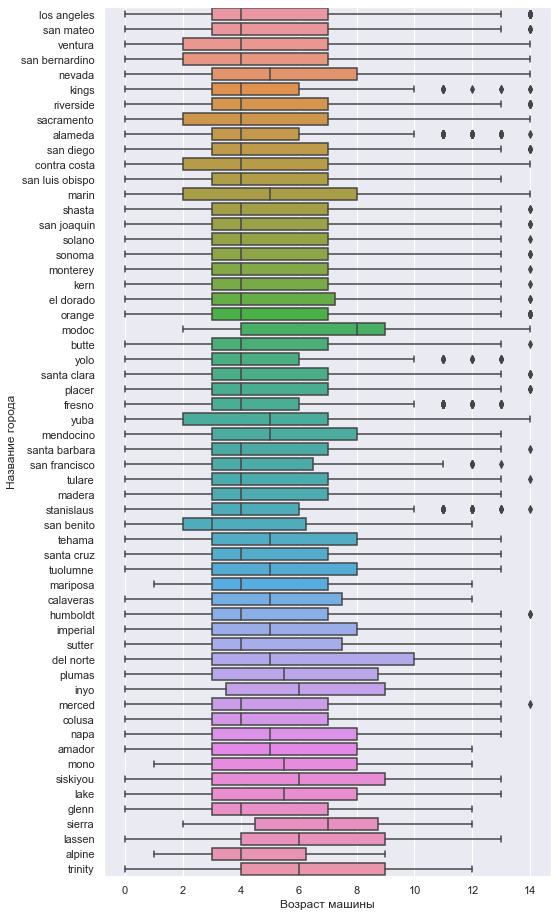

In [45]:
plt.figure(figsize=(8, 16));
sns.boxplot(x=data['vehicle_age'], y=data['county_location']);
plt.xlabel('Возраст машины');
plt.ylabel('Название города');

В каждом городе почти одинаковый возраст у машин, где расходятся слегка, там, вероятно, не так много данных

In [46]:
data.groupby('direction')['at_fault'].mean()

direction
UNK      0.445927
east     0.522689
north    0.522511
south    0.515049
west     0.522711
Name: at_fault, dtype: float64

В каждом направлении шанс 50 процентов, что человек будет виновен.

In [47]:
data.groupby('cellphone_in_use')['at_fault'].mean()

cellphone_in_use
no        0.499891
unknow    0.534444
yes       0.537583
Name: at_fault, dtype: float64

Если нет возможности говорить по телефону, то меньше вероятность быть виновным. Это, наверное, связано с тем, что человек вообще не будет говорить по телефону, следовательно, не будет отвлекаться.

In [48]:
analys_df = data.pivot_table(index=['vehicle_age', 'insurance_premium'], values='at_fault', 
                             aggfunc=['mean', 'count'])
analys_df.columns = analys_df.columns.droplevel()
analys_df.columns = ['Вероятность быть виновным', 'Количество данных']

In [49]:
analys_df[(analys_df['Вероятность быть виновным'] > 0.6) & (analys_df['Количество данных'] > 20)]

Вероятность быть виновным  Количество данных
vehicle_age insurance_premium                                              
0.0         18.0                                0.800000                 25
            19.0                                0.613636                 44
            51.0                                0.615385                 26
1.0         18.0                                0.612903                 31
            28.0                                0.610169                 59
2.0         15.0                                0.820513                 39
            16.0                                0.788991                327
            17.0                                0.720548                730
            18.0                                0.729021               1144
            19.0                                0.632258                465
            20.0                                0.628676                272
            21.0                                0.613497                163
            22.0                                0.614035                114
            24.0                                0.677966                 59
            25.0                                0.657143                 35
3.0         16.0                                0.863636                 22
            17.0                                0.704918                 61
            18.0                                0.686375                389
            19.0                                0.708364               1351
            20.0                                0.670740               1473
            21.0                                0.660365               1534
            22.0                                0.665914               1329
            23.0                                0.636364               1199
            24.0                                0.623541               1028
4.0         18.0                                0.617021                 47
            20.0                                0.654762                 84
7.0         18.0                                0.666667                 33
10.0        58.0                                0.629630                 27
12.0        76.0                                0.613636                 88
            80.0                                0.666667                 75
13.0        81.0                                0.633803                 71
            83.0                                0.654545                 55
            84.0                                0.666667                 57
            85.0                                0.645833                 48

У машин с маленьким возрастом и маленькой страховкой больше вероятность попасть в дтп, у машин с большим возрастом и большой страховкой также большая вероятность попасть в дтп.

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55920 entries, 0 to 56247
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_location       55920 non-null  object 
 1   month_name            55920 non-null  float64
 2   insurance_premium     55373 non-null  float64
 3   party_drug_physical   55920 non-null  object 
 4   cellphone_in_use      55920 non-null  object 
 5   vehicle_type          55920 non-null  object 
 6   vehicle_transmission  55920 non-null  object 
 7   vehicle_age           54230 non-null  float64
 8   direction             55920 non-null  object 
 9   at_fault              55920 non-null  int64  
dtypes: float64(3), int64(1), object(6)
memory usage: 6.7+ MB


In [51]:
df_corr = data.copy()
encoder = OrdinalEncoder()
cat = ['county_location', 'month_name', 'party_drug_physical', 'cellphone_in_use', 'vehicle_transmission']
df_corr[cat] = encoder.fit_transform(df_corr[cat])

In [52]:
df_corr.columns

Index(['county_location', 'month_name', 'insurance_premium',
       'party_drug_physical', 'cellphone_in_use', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age', 'direction', 'at_fault'],
      dtype='object')

In [53]:
def cramers_v(x:float, y:int) -> float:
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))



corr = {'county_location': [cramers_v(df_corr['county_location'], df_corr['cellphone_in_use']), 
                            cramers_v(df_corr['county_location'], df_corr['at_fault'])], 
        'month_name': [cramers_v(df_corr['month_name'], df_corr['cellphone_in_use']), 
                       cramers_v(df_corr['month_name'], df_corr['at_fault'])], 
        'insurance_premium': [cramers_v(df_corr['insurance_premium'], df_corr['cellphone_in_use']), 
                              cramers_v(df_corr['insurance_premium'], df_corr['at_fault'])],
        'party_drug_physical': [cramers_v(df_corr['party_drug_physical'], df_corr['cellphone_in_use']), 
                                cramers_v(df_corr['party_drug_physical'], df_corr['at_fault'])],
        'vehicle_type': [cramers_v(df_corr['vehicle_type'], df_corr['cellphone_in_use']), 
                         cramers_v(df_corr['vehicle_type'], df_corr['at_fault'])],
        'vehicle_transmission': [cramers_v(df_corr['vehicle_transmission'], df_corr['cellphone_in_use']), 
                                 cramers_v(df_corr['vehicle_transmission'], df_corr['at_fault'])],
        'vehicle_age': [cramers_v(df_corr['vehicle_age'], df_corr['cellphone_in_use']), 
                        cramers_v(df_corr['vehicle_age'], df_corr['at_fault'])]}

df_corr_cat = pd.DataFrame(corr, index=['cellphone_in_use', 'at_fault'])

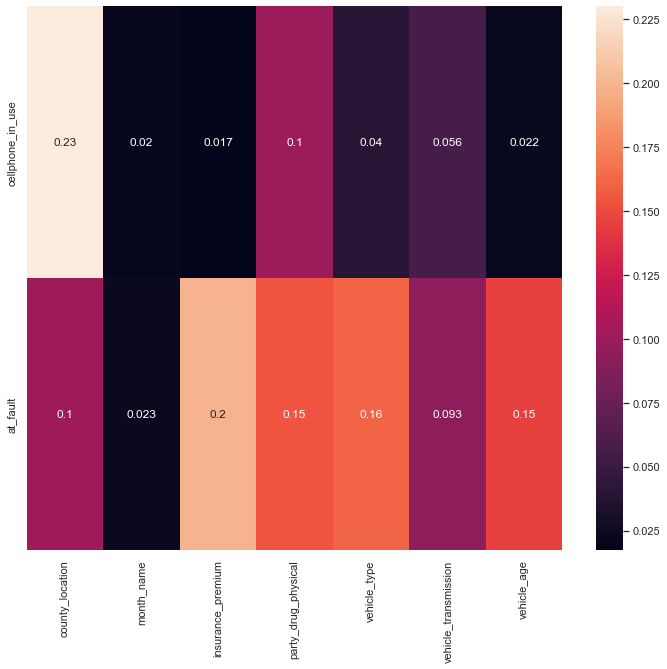

In [54]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr_cat, annot=True);

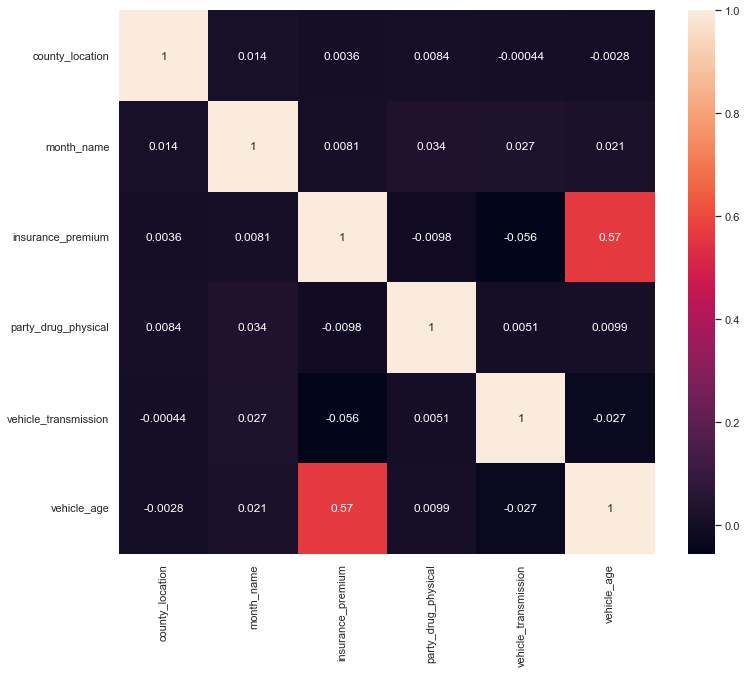

In [55]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr[['county_location', 'month_name', 'insurance_premium', 'party_drug_physical','vehicle_type',
                     'vehicle_transmission', 'vehicle_age']].corr(method='spearman'), annot=True);

Все таки зависимость между возрастом и ценой страховки большая.

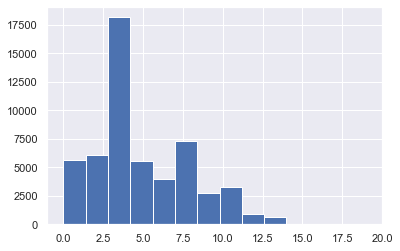

In [56]:
data['vehicle_age'].hist()  
plt.xlim(-1, 20);

In [57]:
data['vehicle_age'].value_counts()

3.0     11007
4.0      7155
2.0      6043
5.0      5564
6.0      3936
7.0      3836
8.0      3505
0.0      3084
9.0      2765
1.0      2541
10.0     1931
11.0     1376
12.0      866
13.0      497
14.0      124
Name: vehicle_age, dtype: int64

In [60]:
data_an['vehicle_age'].value_counts()

 3.0     11007
 4.0      7155
 2.0      6043
 5.0      5564
 6.0      3936
 7.0      3836
 8.0      3505
 0.0      3084
 9.0      2765
 1.0      2541
 10.0     1931
-1.0      1690
 11.0     1376
 12.0      866
 13.0      497
 14.0      124
Name: vehicle_age, dtype: int64

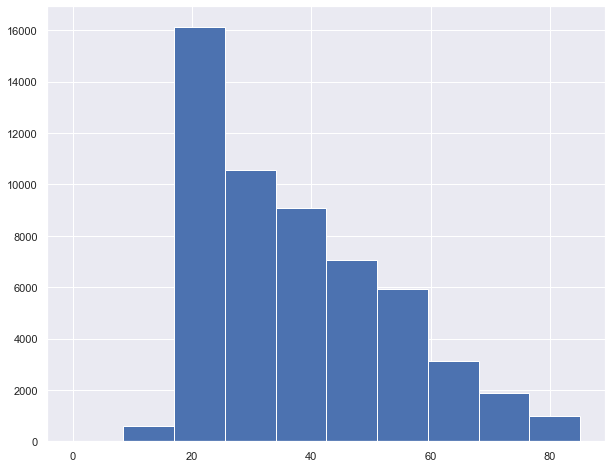

In [61]:
data['insurance_premium'].hist(figsize=(10, 8));

In [63]:
data_an['anomal_insurance'] = data_an['insurance_premium'].apply(lambda x: 1 if x == -1 else 0)
data_an['anomal_age'] = data_an['vehicle_age'].apply(lambda x: 1 if x == -1 else 0)

In [65]:
# косинусо-синусовое преобразование фичи месяца
data_an['mnth_sin'] = np.sin((data_an.month_name-1)*(2.*np.pi/12))
data_an['mnth_cos'] = np.cos((data_an.month_name-1)*(2.*np.pi/12))

## Baseline

In [66]:
features_new = data_an.drop(['at_fault', 'month_name'], axis=1)
target_new = data_an['at_fault']
categories_new = ['county_location', 'party_drug_physical', 'cellphone_in_use', 'vehicle_type', 'vehicle_transmission', 
                  'direction']


In [129]:
features_train, features_test, target_train, target_test = train_test_split(
    features_new, target_new, test_size=0.2, random_state=67, stratify=features_new['vehicle_type'])


In [130]:
features_new

,county_location,insurance_premium,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,direction,anomal_insurance,anomal_age,mnth_sin,mnth_cos
0,los angeles,46.0,not_stated,no,sedan,auto,2.0,south,0,0,1.000000,6.123234e-17
1,san mateo,38.0,not_stated,no,sedan,auto,5.0,east,0,0,0.866025,-5.000000e-01
2,ventura,-1.0,impairment unknow,no,sedan,auto,-1.0,north,1,1,1.000000,6.123234e-17
3,san bernardino,43.0,not_stated,no,sedan,auto,8.0,north,0,0,1.000000,6.123234e-17
4,nevada,38.0,not_stated,no,sedan,auto,6.0,east,0,0,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...
56243,san joaquin,42.0,not_stated,no,coupe,manual,6.0,east,0,0,-0.500000,8.660254e-01
56244,kern,28.0,not_stated,no,coupe,manual,4.0,UNK,0,0,-0.500000,8.660254e-01
56245,los angeles,31.0,under drug influence,no,coupe,manual,5.0,UNK,0,0,0.500000,8.660254e-01
56246,sacramento,55.0,under drug influence,yes,coupe,manual,8.0,south,0,0,0.000000,1.000000e+00


In [131]:
scaler_new = StandardScaler()
numeric_new = ['mnth_sin', 'mnth_cos', 'insurance_premium', 'vehicle_age']
features_train[numeric_new] = scaler_new.fit_transform(features_train[numeric_new])
features_test[numeric_new] = scaler_new.transform(features_test[numeric_new])

# OHE
ohe_new = OneHotEncoder(drop='first')
ohe_df_new_train = ohe_new.fit_transform(np.array(features_train[categories_new]).reshape(-1, 1))
ohe_df_new_train = pd.DataFrame(ohe_df_new_train.todense(), columns=ohe_new.get_feature_names('c'))

ohe_df_new_test = ohe_new.transform(np.array(features_test[categories_new]).reshape(-1, 1))
ohe_df_new_test = pd.DataFrame(ohe_df_new_test.todense(), columns=ohe_new.get_feature_names('c'))

features_train = features_train[['mnth_sin', 'mnth_cos', 'insurance_premium', 'vehicle_age', 'anomal_insurance',
                             'anomal_age']].join(ohe_df_new_train)

features_test = features_test[['mnth_sin', 'mnth_cos', 'insurance_premium', 'vehicle_age', 'anomal_insurance',
                             'anomal_age']].join(ohe_df_new_test)



In [133]:
features_train.head()

,mnth_sin,mnth_cos,insurance_premium,vehicle_age,anomal_insurance,anomal_age,c_alameda,c_alpine,c_amador,c_auto,c_butte,c_calaveras,c_colusa,c_contra costa,c_coupe,c_del norte,c_east,c_el dorado,c_fresno,c_glenn,c_humboldt,c_impairment - physical,c_impairment unknow,c_imperial,c_inyo,...,c_san mateo,c_santa barbara,c_santa clara,c_santa cruz,c_sedan,c_shasta,c_sierra,c_siskiyou,c_sleepy/fatigued,c_solano,c_sonoma,c_south,c_stanislaus,c_sutter,c_tehama,c_trinity,c_tulare,c_tuolumne,c_under drug influence,c_unknow,c_ventura,c_west,c_yes,c_yolo,c_yuba
15908,0.618470,0.278473,-0.793964,-0.514955,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55314,-0.252316,0.903992,0.066966,-1.467831,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47675,0.937200,-0.576002,0.251451,0.437920,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6406,0.937200,-0.576002,0.189956,0.437920,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36958,-1.441833,1.132948,-0.855459,-0.514955,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

**RandomForestClassifier**

In [136]:
forest = RandomForestClassifier(n_estimators=100,
                                max_features='sqrt', 
                                max_depth=12,
                                class_weight='balanced',
                                n_jobs = -1)

forest.fit(features_train, target_train)
prediction = forest.predict_proba(features_test)[:, 1]
print(roc_auc_score(target_test, prediction)) 

0.619766176965921


---

**LogisticRegression**

In [95]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(features_train, target_train)
prediction = logreg.predict_proba(features_test)[:, 1]
print(roc_auc_score(target_test, prediction))

0.599929439828417


Чуть хуже леса

---

## Улучшение моделей

**LogReg**

In [100]:
parameters = {
    'penalty': ['l1' , 'l2', 'elasticnet'],
    'C': [0.1, 0.2, 0.4, 1]
}


lr = LogisticRegression(class_weight='balanced')
gs = GridSearchCV(lr, parameters, cv=10, n_jobs=-1, scoring='roc_auc')
gs.fit(features_train, target_train)

GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.4, 1],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='roc_auc')

In [114]:
gs.best_score_, gs.best_params_

(0.594494465665072, {'C': 0.1, 'penalty': 'l2'})

In [102]:
prediction = gs.best_estimator_.predict_proba(features_test)[:, 1]
print(roc_auc_score(target_test, prediction))

0.6020859016920241


---

**RandomForestClassifier**

In [107]:
parameters = {
    'n_estimators': [100, 200, 400, 800, 1000],
    'max_depth': [6, 12, 18]
}


rfc = RandomForestClassifier(max_features='sqrt',
                             class_weight='balanced')
gs = GridSearchCV(rfc, parameters, cv=10, n_jobs=-1, scoring='roc_auc')
gs.fit(features_train, target_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt'),
             n_jobs=-1,
             param_grid={'max_depth': [6, 12, 18],
                         'n_estimators': [100, 200, 400, 800, 1000]},
             scoring='roc_auc')

In [108]:
gs.best_score_, gs.best_params_

(0.6151007313284994, {'max_depth': 12, 'n_estimators': 400})

In [109]:
prediction = gs.best_estimator_.predict_proba(features_test)[:, 1]
print(roc_auc_score(target_test, prediction))

0.6212842296625328


Леса получаются лучше, использую деревянные модели

---

**LightGBM**

In [111]:
%%time

parameters = {
    'n_estimators': [100, 200, 400, 800],
    'max_depth': [6, 12, 18],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [12, 24, 36]
}


lgbm = LGBMClassifier(class_weight='balanced')
gs = GridSearchCV(lgbm, parameters, cv=10, n_jobs=-1, scoring='roc_auc')
gs.fit(features_train, target_train)

Wall time: 1min 51s


GridSearchCV(cv=10, estimator=LGBMClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12, 18],
                         'n_estimators': [100, 200, 400, 800],
                         'num_leaves': [12, 24, 36]},
             scoring='roc_auc')

In [112]:
gs.best_score_, gs.best_params_

(0.6242921073314385,
 {'learning_rate': 0.01,
  'max_depth': 12,
  'n_estimators': 400,
  'num_leaves': 12})

In [113]:
prediction = gs.best_estimator_.predict_proba(features_test)[:, 1]
print(roc_auc_score(target_test, prediction))

0.6332238434854314


### Догонка гиперпараметров с помощью optuna

In [126]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 10, 12),
        'n_estimators': trial.suggest_int('n_estimators', 360, 420, 20),
        'num_leaves': trial.suggest_int('num_leaves', 20, 24),
        'learning_rate': [0.01]
    }

    
    # задаём модели требуемые параметры    
    model=LGBMClassifier(**params)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=model, X=features_train, y=target_train, 
                            scoring='roc_auc', cv=10, n_jobs=-1)

    
    return score.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-08-03 11:30:28,471] A new study created in memory with name: no-name-fbf0ae37-a00a-4b4c-880e-ed15876d96bf
[I 2022-08-03 11:30:30,681] Trial 0 finished with value: 0.625932551929069 and parameters: {'max_depth': 11, 'n_estimators': 360, 'num_leaves': 22}. Best is trial 0 with value: 0.625932551929069.
[I 2022-08-03 11:30:32,754] Trial 1 finished with value: 0.6259884462838952 and parameters: {'max_depth': 12, 'n_estimators': 380, 'num_leaves': 22}. Best is trial 1 with value: 0.6259884462838952.
[I 2022-08-03 11:30:34,985] Trial 2 finished with value: 0.6260191435349279 and parameters: {'max_depth': 11, 'n_estimators': 400, 'num_leaves': 21}. Best is trial 2 with value: 0.6260191435349279.
[I 2022-08-03 11:30:37,270] Trial 3 finished with value: 0.6258952554534135 and parameters: {'max_depth': 12, 'n_estimators': 380, 'num_leaves': 24}. Best is trial 2 with value: 0.6260191435349279.
[I 2022-08-03 11:30:39,598] Trial 4 finished with value: 0.6258949679827615 and parameters: {'ma

In [127]:
study.best_params, study.best_value

({'max_depth': 12, 'n_estimators': 380, 'num_leaves': 21}, 0.6261340957912389)

In [116]:
lgbm = LGBMClassifier(learning_rate=0.01, 
                      max_depth=12, 
                      num_leaves=21, 
                      n_estimators=380, 
                      class_weight='balanced')
lgbm.fit(features_train, target_train)
prediction = lgbm.predict_proba(features_test)[:, 1]
print(roc_auc_score(target_test, prediction))

0.6319679408710688


In [117]:
# Произвожу кросс-валидацию
params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 232
params['custom_loss'] = 'AUC'
params['random_seed'] = 67
params['learning_rate'] = 0.01

cv_data = cv(
    params = params,
    pool = Pool(features_train, label=target_train),
    fold_count=10,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]

bestTest = 0.66917779
bestIteration = 231

Training on fold [1/10]

bestTest = 0.6708430148
bestIteration = 231

Training on fold [2/10]

bestTest = 0.6706908494
bestIteration = 231

Training on fold [3/10]

bestTest = 0.6673015468
bestIteration = 231

Training on fold [4/10]

bestTest = 0.6695331397
bestIteration = 231

Training on fold [5/10]

bestTest = 0.6660925181
bestIteration = 231

Training on fold [6/10]

bestTest = 0.6743960876
bestIteration = 231

Training on fold [7/10]

bestTest = 0.6712926999
bestIteration = 231

Training on fold [8/10]

bestTest = 0.6682012625
bestIteration = 231

Training on fold [9/10]

bestTest = 0.6700006607
bestIteration = 231



In [118]:
cv_data['test-AUC-mean'].mean(), cv_data['test-AUC-std'].mean()

(0.6217243337896702, 0.007603345204970329)

In [119]:
model = CatBoostClassifier(
    iterations=232,
    learning_rate=0.01,
    random_seed=67,
    custom_loss='AUC',
    use_best_model=True)

model.fit(
    features_train, target_train,
    eval_set=(features_test, target_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [120]:
prediction = model.predict_proba(features_test)[:,1]
print(roc_auc_score(target_test, prediction))

0.6321052522506145


# Лучшая модель

Выбрал CatBoost, т.к. предсказывал лучше остальных.

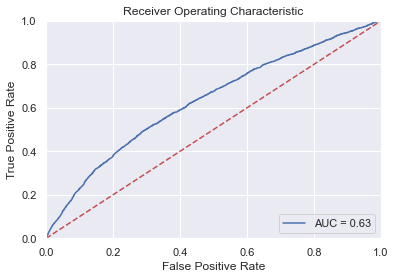

In [137]:
probs = model.predict_proba(features_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(target_test, preds)


roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [138]:
confusion_matrix(target_test, model.predict(features_test))

array([[3866, 1680],
       [2791, 2847]], dtype=int64)

Маленький recall, и относительно маленький precision, который больше recall

In [139]:
recall_score(target_test, model.predict(features_test)), precision_score(target_test, model.predict(features_test))

(0.5049663001064207, 0.6288933068257124)

In [140]:
model.feature_importances_

array([2.72199024e+00, 2.98452876e+00, 6.49534956e+01, 2.69360091e+01,
       3.23135746e-01, 3.72241805e-02, 2.07593806e-02, 1.57559340e-02,
       8.03745133e-03, 7.73398191e-02, 9.64281584e-03, 3.92905869e-02,
       5.86364674e-03, 0.00000000e+00, 1.08737628e-02, 1.09296055e-02,
       7.66141628e-02, 3.95029610e-02, 0.00000000e+00, 0.00000000e+00,
       3.36391140e-02, 0.00000000e+00, 3.64570770e-02, 9.16219356e-02,
       1.07171984e-02, 4.52272148e-02, 6.63436604e-03, 5.34709112e-03,
       8.94377532e-03, 4.15059358e-02, 5.49861553e-02, 1.45545211e-01,
       8.42381309e-03, 0.00000000e+00, 1.82483602e-02, 0.00000000e+00,
       4.75887762e-03, 0.00000000e+00, 1.12752548e-02, 5.76448930e-03,
       4.57818078e-02, 2.31424855e-02, 2.29567811e-02, 2.75619016e-02,
       3.65946592e-02, 1.46049846e-01, 1.02576329e-01, 5.62488710e-05,
       3.90317252e-02, 0.00000000e+00, 4.32252022e-02, 0.00000000e+00,
       1.44699462e-03, 2.65211909e-02, 2.40038878e-02, 6.58057529e-02,
      

Выбираю первые 4 признака, т.к. остальные имеют слишком маленькую важность.

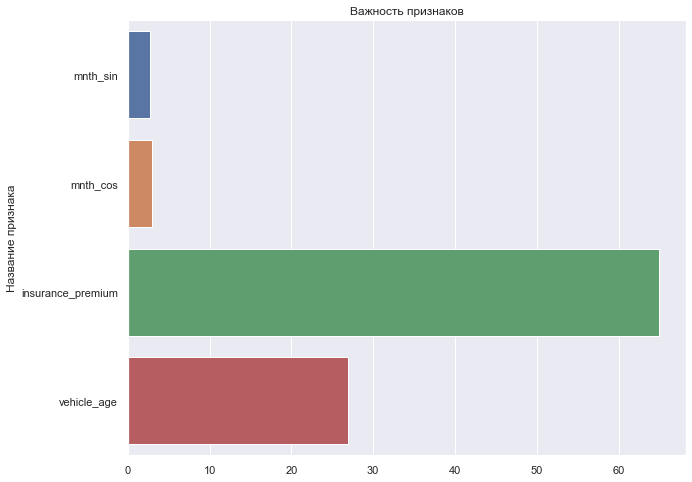

In [141]:
plt.figure(figsize=(10, 8))
sns.barplot(y=features_train.columns[:4], x=model.feature_importances_[:4]);
plt.title('Важность признаков');
plt.ylabel('Название признака');

Что можно сказать на счет важности, важны на самом деле 2 признака, это сумма страховки и возраст машины.

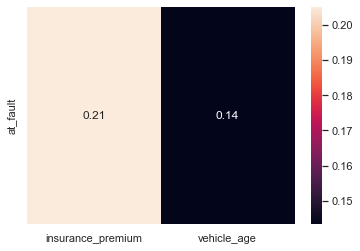

In [142]:
df_corr = {'insurance_premium': [cramers_v(data_an['insurance_premium'], data_an['at_fault'])], 
           'vehicle_age': [cramers_v(data_an['vehicle_age'], data_an['at_fault'])]}

sns.heatmap(pd.DataFrame(df_corr, index=['at_fault']), annot=True);

Есть зависимость, но она не очень высокая, можно предполагать, что чем дороже страховка, тем больше шансов быть виноватым в дтп, и чем выше возраст машины, тем также больше вероятность быть виноватым, да и в целом попасть в дтп.

Можно ли по этим признакам добавить что-то в машину, нет, это итак известно при аренде автомобиля. Но как дополнение, можно оборудовать автомобиль датчиком, либо камерой, которая может распозовать состояние человека в целом(трезвость и самочувствие), т.к. арендовать мог человек трезвый, а потом выпить и попасть в дтп.

### SHAP

In [257]:
shap_values = shap.TreeExplainer(model).shap_values(features_test)
features_test.shape

(11184, 83)

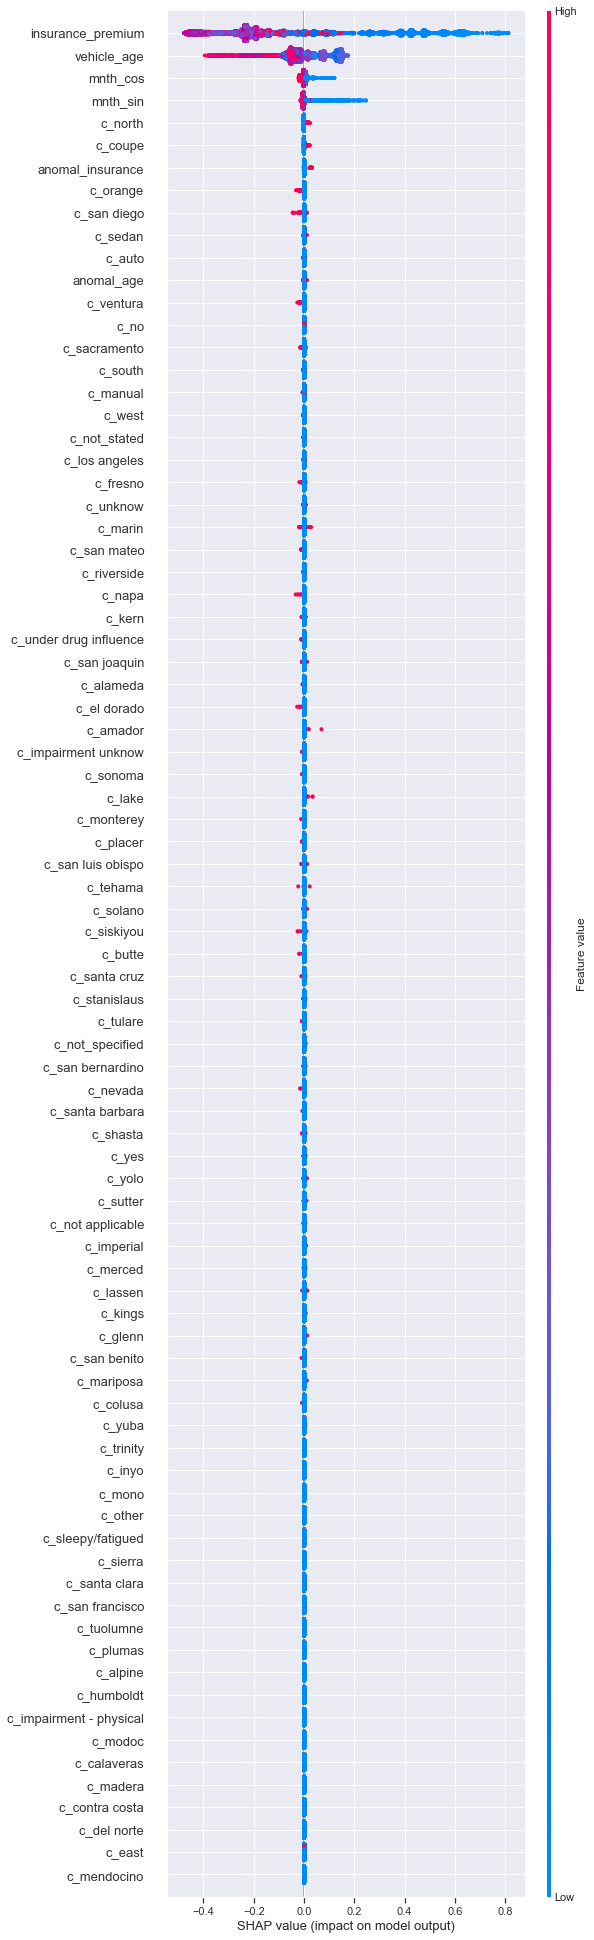

In [259]:
shap.summary_plot(shap_values, features_test, max_display=83)

Получается так, что чем ниже сумма страховки у автомобиля, то тем выше вероятность быть виновным в дтп, хотя есть некоторая группа таких автомобилей, которые имеют маленькую вероятность при маленькой сумме страховки. На счет увелечения страховки - чем выше сумму страховки, тем ниже вероятность быть виновным.

Важен признак возраста авто. Чем выше возраст авто, тем ниже вероятность быть виновным, и наоборот, чем меньше возраст, тем выше вероятность быть виновным.

Слегка влияет месяц, но данные у нас в основном за несколько месяцев, но зависимость такова, что в 1 полугодии выше вероятность быть виновным.

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Финальный вывод<a class="tocSkip"> </h2>
Можно ли сделать адекватную систему? Да, можно, но для этого нужно больше данных, а точнее: название главное дороги, тип дороги(в целом эти 2 признака могут помочь опозновать то, где чаще всего происходят дтп и уже можно предсказывать вероятности того, что на каком-то участе с вероятностью ... будет дтп), допустим, откуда и куда держится путь(допустим, есть маршрут от Москвы до Питера, их там какое-то количество и на каждом случаются дтп. Желательно давать сравнение модели с машинами, которые не попали в аварию и теми, кто попал, а у нас данных только по тем, кто попал. Мы либо предсказываем среднюю вероятность того, что человек попадет дтп на основе большого количества данных, либо добавляем столбец с типом дорог, по которой будет ехать авто и уже иметь более точную вероятность попадания в дтп). По данным, которые есть на данный момент, нельзя построить нормальную систему оценки вероятности дтп, т.к. важность в оценке имеет всего 2 признака, возраст авто и страховка. 
    
    
Также неправильный целевой признак. Получается так, что у нас целевой признак - виноват/не виноват пострадавший в дтп, т.е. он уже сто процентов попал в дтп. Нашим целевым признаком должно быть состояние автомобиль после аварии, т.к. нам желательно, чтобы автомобиль был целым, либо же с царапиной, а не то, кто будет виноват или нет.